In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

🧩 Classes: ['Benign', 'Early', 'Pre', 'Pro']
Train: 2279 | Val: 651 | Test: 326


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch [1/10] Train Loss: 1.3354, Train Acc: 49.63% | Val Loss: 0.8454, Val Acc: 70.20%
✅ Best model updated at epoch 1
Epoch [2/10] Train Loss: 0.6683, Train Acc: 83.59% | Val Loss: 0.5379, Val Acc: 92.78%
✅ Best model updated at epoch 2
Epoch [3/10] Train Loss: 0.5535, Train Acc: 91.27% | Val Loss: 0.5581, Val Acc: 89.40%
Epoch [4/10] Train Loss: 0.5194, Train Acc: 92.15% | Val Loss: 0.4897, Val Acc: 92.93%
✅ Best model updated at epoch 4
Epoch [5/10] Train Loss: 0.4385, Train Acc: 96.05% | Val Loss: 0.4626, Val Acc: 95.08%
✅ Best model updated at epoch 5
Epoch [6/10] Train Loss: 0.4047, Train Acc: 97.59% | Val Loss: 0.4393, Val Acc: 96.16%
✅ Best model updated at epoch 6
Epoch [7/10] Train Loss: 0.3836, Train Acc: 98.64% | Val Loss: 0.4272, Val Acc: 97.08%
✅ Best model updated at epoch 7
Epoch [8/10] Train Loss: 0.3666, Train Acc: 99.12% | Val Loss: 0.4415, Val Acc: 96.31%
Epoch [9/10] Train Loss: 0.3563, Train Acc: 99.78% | Val Loss: 0.4168, Val Acc: 97.08%
Epoch [10/10] Train Loss:

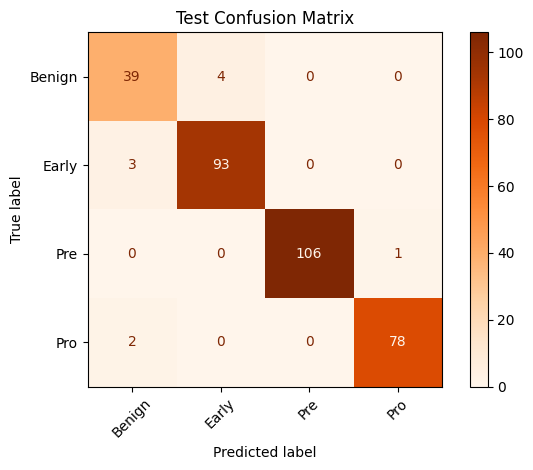

💾 Final model saved as 'vit_final_model_stable.pth'


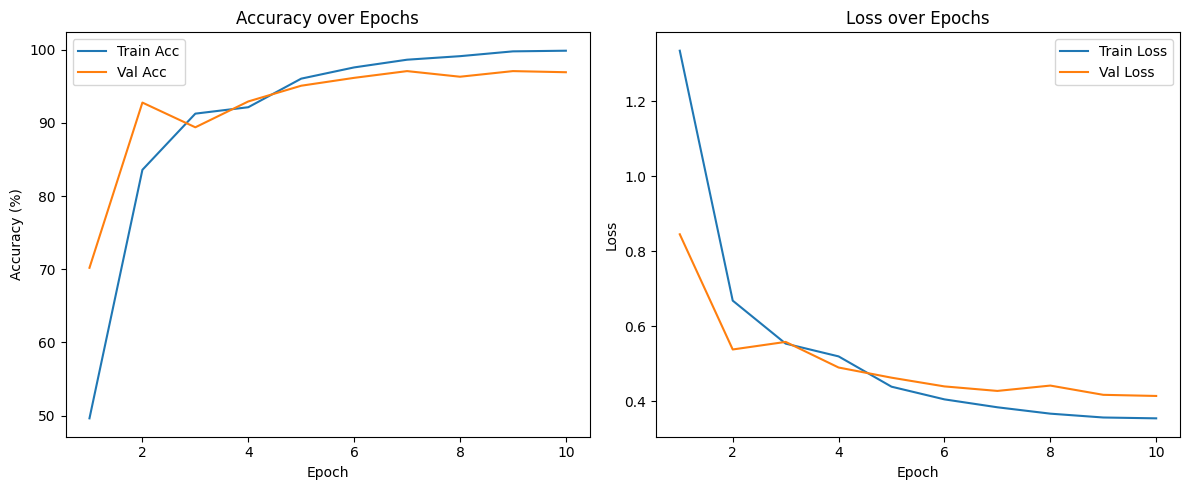

In [1]:
# ==========================================================
# Leukemia Classification with Vision Transformer (ViT)
# Stable Training with Scheduler and Regularization
# ==========================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import os

# =============================
# Configuration
# =============================
data_dir = "/kaggle/input/leukemia/Original"
batch_size = 32
num_epochs = 10
num_classes = 4
learning_rate = 3e-4
weight_decay = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================
# Data Preparation
# =============================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(360),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

# ---- Load dataset ----
base_dataset = datasets.ImageFolder(root=data_dir)

# ---- Split dataset: Train (70%) | Val (20%) | Test (10%) ----
total_size = len(base_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    base_dataset, [train_size, val_size, test_size]
)

# ---- Assign transforms ----
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# ---- Data loaders ----
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class_names = base_dataset.classes
print(f"🧩 Classes: {class_names}")
print(f"Train: {train_size} | Val: {val_size} | Test: {test_size}")

# =============================
# Model Setup (Vision Transformer)
# =============================
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Add dropout in head for regularization
model.head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.head.in_features, num_classes)
)
model.to(device)

# Loss with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler (cosine annealing)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# =============================
# Training and Validation Loop
# =============================
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0.0
os.makedirs("checkpoints", exist_ok=True)

for epoch in range(num_epochs):
    # ---- TRAIN ----
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # ---- VALIDATION ----
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Update scheduler
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "checkpoints/vit_best.pth")
        print(f"✅ Best model updated at epoch {epoch+1}")

print("🎉 Training complete!")
print(f"📦 Best Validation Accuracy: {best_val_acc:.2f}%")

# =============================
# Final Evaluation on Test Data
# =============================
model.load_state_dict(torch.load("checkpoints/vit_best.pth", map_location=device))
model.eval()

test_labels, test_preds = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

print("\n🧪 Test Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

cm_test = confusion_matrix(test_labels, test_preds)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names)
disp_test.plot(cmap=plt.cm.Oranges, xticks_rotation=45)
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

# =============================
# Save Final Model
# =============================
torch.save(model, "vit_final_model_stable.pth")
print("💾 Final model saved as 'vit_final_model_stable.pth'")

# =============================
# Plot Accuracy and Loss Curves
# =============================
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs, label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
!pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 

✅ Loaded state_dict from checkpoints/vit_best.pth
🖼️ Using image: /kaggle/input/leukemia/Original/Benign/WBC-Benign-001.jpg


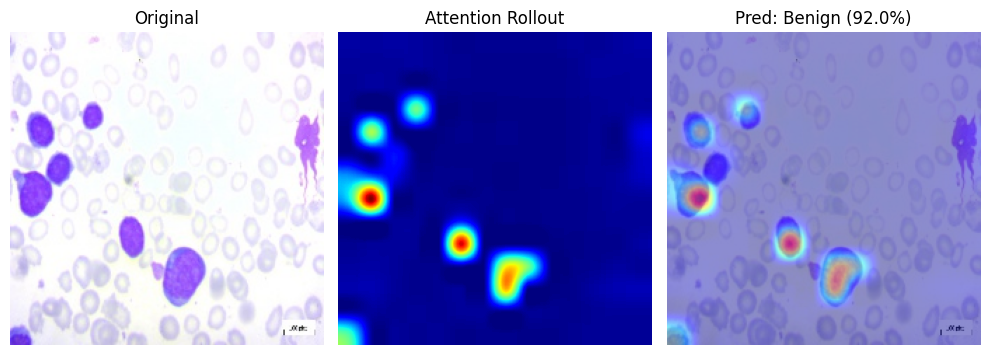

In [2]:
"""
✅ FIXED Attention Rollout for timm Vision Transformer
Works with all timm ViTs including vit_base_patch16_224
"""

import torch
import torch.nn.functional as F
import numpy as np
import timm
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================================
# 1️⃣ Preprocessing
# ================================
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

def unnormalize_tensor(img_tensor):
    mean = torch.tensor([0.5,0.5,0.5])[:, None, None]
    std = torch.tensor([0.5,0.5,0.5])[:, None, None]
    img = img_tensor.cpu() * std + mean
    img = torch.clamp(img, 0, 1)
    return img.permute(1,2,0).numpy()

# ================================
# 2️⃣ Load your trained ViT model
# ================================
def load_vit_model(model_path, num_classes=4, device=device):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = torch.nn.Sequential(
        torch.nn.Dropout(0.3),
        torch.nn.Linear(model.head.in_features, num_classes)
    )
    model.to(device)

    state = torch.load(model_path, map_location=device)
    if isinstance(state, dict) and all(isinstance(k, str) for k in state.keys()):
        model.load_state_dict(state)
        print(f"✅ Loaded state_dict from {model_path}")
    else:
        model.load_state_dict(state.state_dict())
        print(f"✅ Loaded full model from {model_path}")
    model.eval()
    return model

# ================================
# 3️⃣ Hook-based Attention Rollout
# ================================
# ==============================================
# ✅ Hook Correctly into ViT Attention Forward
# ==============================================

def get_attention_maps(model, input_tensor):
    """
    Collect raw attention weights from all transformer blocks via forward hooks.
    Compatible with timm >= 1.0 Vision Transformers.
    """
    attn_maps = []

    def forward_hook(module, input, output):
        # We can reconstruct the attention weights manually since they are computed from qkv
        B, N, C = input[0].shape
        qkv = module.qkv(input[0])
        qkv = qkv.reshape(B, N, 3, module.num_heads, C // module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = attn.softmax(dim=-1)
        attn_maps.append(attn.detach().cpu())

    # Register hooks on each attention block
    hooks = []
    for blk in model.blocks:
        h = blk.attn.register_forward_hook(forward_hook)
        hooks.append(h)

    # Forward pass
    with torch.no_grad():
        _ = model(input_tensor)

    # Remove hooks
    for h in hooks:
        h.remove()

    return attn_maps


def compute_attention_rollout(model, input_tensor):
    """
    Compute attention rollout given all attention maps.
    """
    attn_maps = get_attention_maps(model, input_tensor)
    if len(attn_maps) == 0:
        raise RuntimeError("❌ No attention maps captured — check hook connections.")

    attn_mean = [a.mean(dim=1) for a in attn_maps]  # average over heads

    result = torch.eye(attn_mean[0].size(-1))
    for attn in attn_mean:
        attn = attn + torch.eye(attn.size(-1))
        attn = attn / attn.sum(dim=-1, keepdim=True)
        result = torch.matmul(attn, result)

    mask = result[0, 0, 1:]  # exclude CLS token
    width = height = int(mask.size(0) ** 0.5)
    mask = mask.reshape(width, height).numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)
    return mask



# ================================
# 4️⃣ Visualization
# ================================
def visualize_attention_rollout(model, image_path, class_names=None):
    img = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    # Prediction
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)
    pred_idx = probs.argmax(dim=1).item()
    conf = probs[0, pred_idx].item()

    # Compute rollout
    attn_map = compute_attention_rollout(model, input_tensor)

    # Resize to input
    attn_map_resized = np.array(Image.fromarray((attn_map * 255).astype(np.uint8)).resize((224, 224)))
    attn_map_resized = attn_map_resized / 255.0

    img_np = unnormalize_tensor(input_tensor[0])
    heatmap = plt.get_cmap("jet")(attn_map_resized)[:, :, :3]
    overlay = 0.45 * heatmap + 0.55 * img_np
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(attn_map_resized, cmap="jet")
    plt.title("Attention Rollout")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    pred_label = class_names[pred_idx] if class_names else str(pred_idx)
    plt.title(f"Pred: {pred_label} ({conf*100:.1f}%)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return attn_map, overlay


# ================================
# 5️⃣ Example Run
# ================================
if __name__ == "__main__":
    # Load model
    model_path = None
    for p in ["checkpoints/vit_best.pth", "vit_final_model_stable.pth"]:
        if os.path.exists(p):
            model_path = p
            break
    if model_path is None:
        raise FileNotFoundError("No trained model found!")

    model = load_vit_model(model_path, num_classes=4, device=device)
    class_names = ['Benign', 'Early', 'Pre', 'Pro']  # replace with actual labels

    # Example image
    data_dir = "/kaggle/input/leukemia/Original"
    sample_path = "/kaggle/input/leukemia/Original/Benign/WBC-Benign-001.jpg"
    for root, _, files in os.walk(data_dir):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                sample_path = os.path.join(root, f)
                break
        if sample_path:
            break

    print("🖼️ Using image:", sample_path)
    visualize_attention_rollout(model, sample_path, class_names)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✅ Loaded state_dict from checkpoints/vit_best.pth
🖼️ Using image: /kaggle/input/leukemia/Original/Benign/WBC-Benign-001.jpg


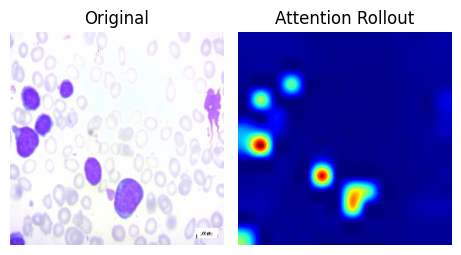

In [1]:
"""
✅ FIXED Attention Rollout for timm Vision Transformer
Works with all timm ViTs including vit_base_patch16_224
"""

import torch
import torch.nn.functional as F
import numpy as np
import timm
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================================
# 1️⃣ Preprocessing
# ================================
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

def unnormalize_tensor(img_tensor):
    mean = torch.tensor([0.5,0.5,0.5])[:, None, None]
    std = torch.tensor([0.5,0.5,0.5])[:, None, None]
    img = img_tensor.cpu() * std + mean
    img = torch.clamp(img, 0, 1)
    return img.permute(1,2,0).numpy()

# ================================
# 2️⃣ Load your trained ViT model
# ================================
def load_vit_model(model_path, num_classes=4, device=device):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = torch.nn.Sequential(
        torch.nn.Dropout(0.3),
        torch.nn.Linear(model.head.in_features, num_classes)
    )
    model.to(device)

    state = torch.load(model_path, map_location=device)
    if isinstance(state, dict) and all(isinstance(k, str) for k in state.keys()):
        model.load_state_dict(state)
        print(f"✅ Loaded state_dict from {model_path}")
    else:
        model.load_state_dict(state.state_dict())
        print(f"✅ Loaded full model from {model_path}")
    model.eval()
    return model

# ================================
# 3️⃣ Hook-based Attention Rollout
# ================================
# ==============================================
# ✅ Hook Correctly into ViT Attention Forward
# ==============================================

def get_attention_maps(model, input_tensor):
    """
    Collect raw attention weights from all transformer blocks via forward hooks.
    Compatible with timm >= 1.0 Vision Transformers.
    """
    attn_maps = []

    def forward_hook(module, input, output):
        # We can reconstruct the attention weights manually since they are computed from qkv
        B, N, C = input[0].shape
        qkv = module.qkv(input[0])
        qkv = qkv.reshape(B, N, 3, module.num_heads, C // module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = attn.softmax(dim=-1)
        attn_maps.append(attn.detach().cpu())

    # Register hooks on each attention block
    hooks = []
    for blk in model.blocks:
        h = blk.attn.register_forward_hook(forward_hook)
        hooks.append(h)

    # Forward pass
    with torch.no_grad():
        _ = model(input_tensor)

    # Remove hooks
    for h in hooks:
        h.remove()

    return attn_maps


def compute_attention_rollout(model, input_tensor):
    """
    Compute attention rollout given all attention maps.
    """
    attn_maps = get_attention_maps(model, input_tensor)
    if len(attn_maps) == 0:
        raise RuntimeError("❌ No attention maps captured — check hook connections.")

    attn_mean = [a.mean(dim=1) for a in attn_maps]  # average over heads

    result = torch.eye(attn_mean[0].size(-1))
    for attn in attn_mean:
        attn = attn + torch.eye(attn.size(-1))
        attn = attn / attn.sum(dim=-1, keepdim=True)
        result = torch.matmul(attn, result)

    mask = result[0, 0, 1:]  # exclude CLS token
    width = height = int(mask.size(0) ** 0.5)
    mask = mask.reshape(width, height).numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)
    return mask



# ================================
# 4️⃣ Visualization
# ================================
def visualize_attention_rollout(model, image_path, class_names=None):
    img = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    # Prediction
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)
    pred_idx = probs.argmax(dim=1).item()
    conf = probs[0, pred_idx].item()

    # Compute rollout
    attn_map = compute_attention_rollout(model, input_tensor)

    # Resize to input
    attn_map_resized = np.array(Image.fromarray((attn_map * 255).astype(np.uint8)).resize((224, 224)))
    attn_map_resized = attn_map_resized / 255.0

    img_np = unnormalize_tensor(input_tensor[0])
    heatmap = plt.get_cmap("jet")(attn_map_resized)[:, :, :3]
    overlay = 0.45 * heatmap + 0.55 * img_np
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(7,3))
    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(attn_map_resized, cmap="jet")
    plt.title("Attention Rollout")
    plt.axis("off")

    #plt.subplot(1,3,3)
    #plt.imshow(overlay)
    #pred_label = class_names[pred_idx] if class_names else str(pred_idx)
    #plt.title(f"Pred: {pred_label} ({conf*100:.1f}%)")
    #plt.axis("off")

    plt.tight_layout()
    plt.show()

    return attn_map, overlay


# ================================
# 5️⃣ Example Run
# ================================
if __name__ == "__main__":
    # Load model
    model_path = None
    for p in ["checkpoints/vit_best.pth", "vit_final_model_stable.pth"]:
        if os.path.exists(p):
            model_path = p
            break
    if model_path is None:
        raise FileNotFoundError("No trained model found!")

    model = load_vit_model(model_path, num_classes=4, device=device)
    class_names = ['Benign', 'Early', 'Pre', 'Pro']  # replace with actual labels

    # Example image
    data_dir = "/kaggle/input/leukemia/Original"
    sample_path = "/kaggle/input/leukemia/Original/Benign/WBC-Benign-001.jpg"
    for root, _, files in os.walk(data_dir):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                sample_path = os.path.join(root, f)
                break
        if sample_path:
            break

    print("🖼️ Using image:", sample_path)
    visualize_attention_rollout(model, sample_path, class_names)


Selected images:
   /kaggle/input/leukemia/Original/Benign/WBC-Benign-210.jpg
   /kaggle/input/leukemia/Original/Early/WBC-Malignant-Early-734.jpg
   /kaggle/input/leukemia/Original/Pre/WBC-Malignant-Pre-685.jpg
   /kaggle/input/leukemia/Original/Pro/WBC-Malignant-Pro-722.jpg


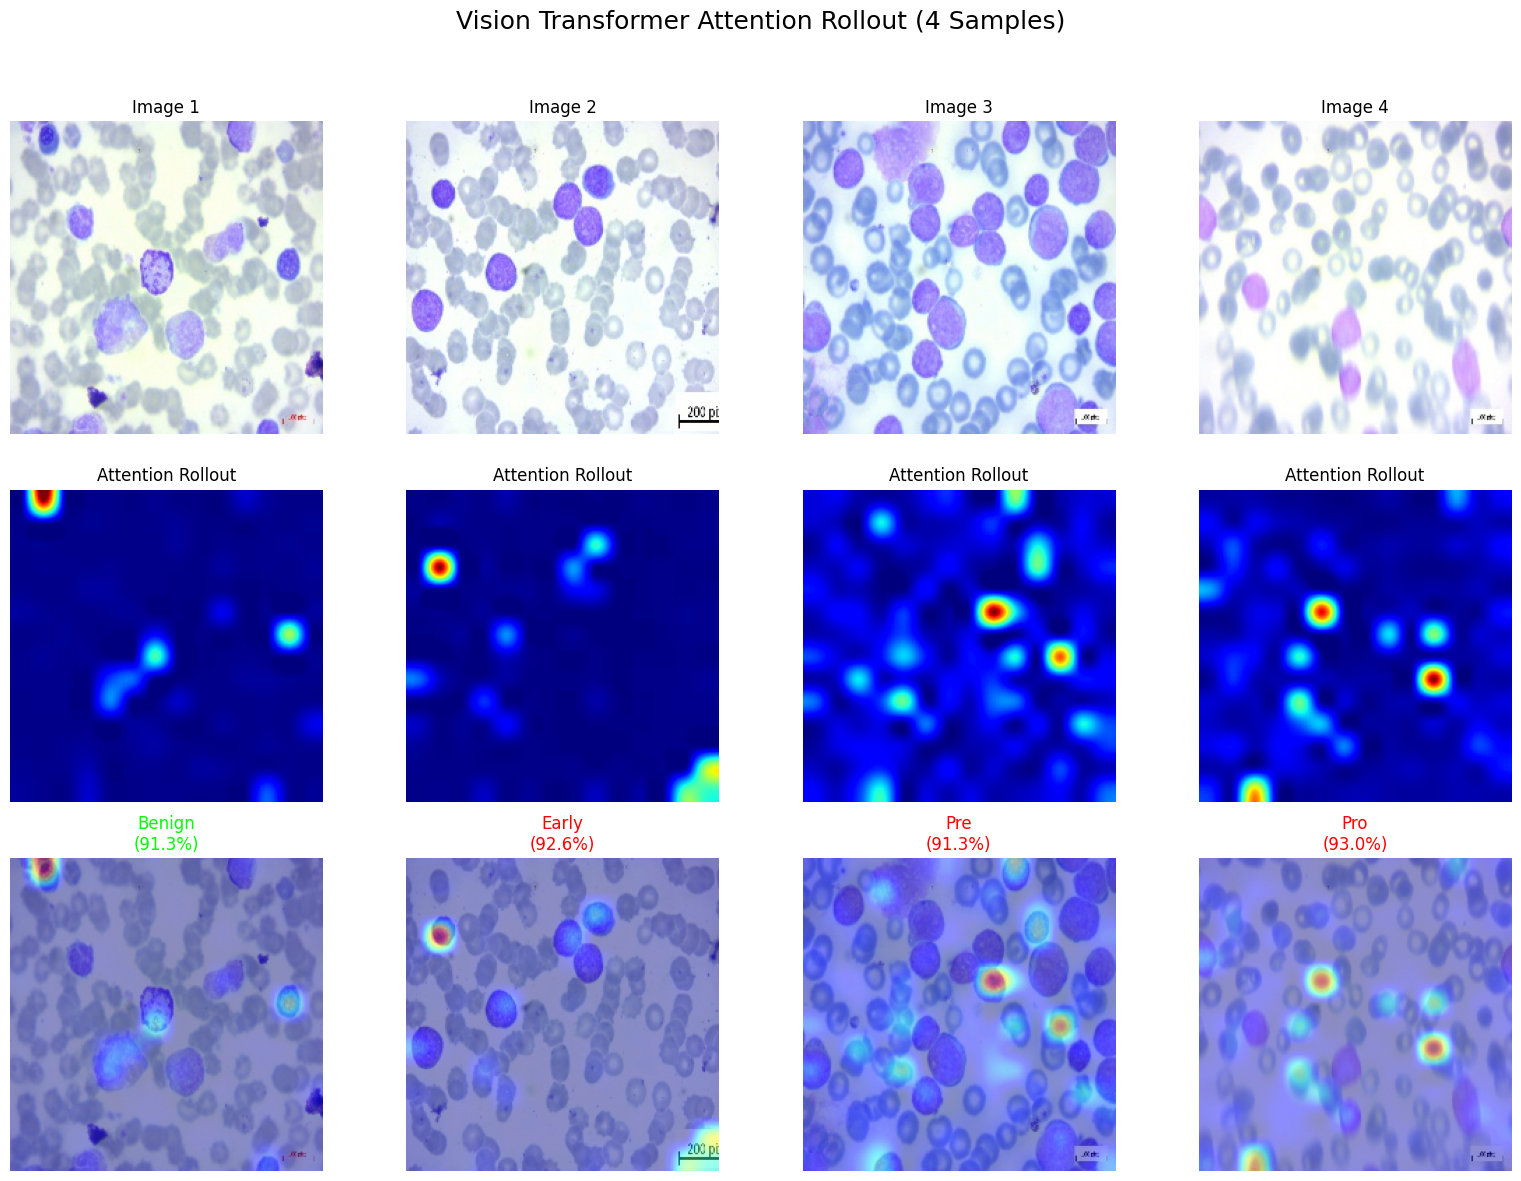

In [2]:
"""
✅ FIXED Attention Rollout for timm Vision Transformer
Now visualizes 4 images in a 3×4 grid:
Row 1 → 4 original images
Row 2 → 4 attention rollout heatmaps
Row 3 → 4 overlayed images with prediction
"""

import torch
import torch.nn.functional as F
import numpy as np
import timm
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================================
# 1️⃣ Preprocessing
# ================================
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

def unnormalize_tensor(img_tensor):
    mean = torch.tensor([0.5, 0.5, 0.5])[:, None, None]
    std = torch.tensor([0.5, 0.5, 0.5])[:, None, None]
    img = img_tensor.cpu() * std + mean
    return torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()

# ================================
# 2️⃣ Load Model
# ================================
def load_vit_model(model_path, num_classes=4, device=device):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = torch.nn.Sequential(
        torch.nn.Dropout(0.3),
        torch.nn.Linear(model.head.in_features, num_classes)
    )
    model.to(device)
    state = torch.load(model_path, map_location=device)
    if isinstance(state, dict) and all(isinstance(k, str) for k in state.keys()):
        model.load_state_dict(state)
    else:
        model.load_state_dict(state.state_dict())
    model.eval()
    return model

# ================================
# 3️⃣ Attention Rollout (unchanged)
# ================================
def get_attention_maps(model, input_tensor):
    attn_maps = []
    def forward_hook(module, input, output):
        B, N, C = input[0].shape
        qkv = module.qkv(input[0]).reshape(B, N, 3, module.num_heads, C // module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, _ = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = attn.softmax(dim=-1)
        attn_maps.append(attn.detach().cpu())
    
    hooks = [blk.attn.register_forward_hook(forward_hook) for blk in model.blocks]
    with torch.no_grad():
        _ = model(input_tensor)
    for h in hooks:
        h.remove()
    return attn_maps

def compute_attention_rollout(model, input_tensor):
    attn_maps = get_attention_maps(model, input_tensor)
    if not attn_maps:
        raise RuntimeError("No attention maps captured")
    
    attn_mean = [a.mean(dim=1) for a in attn_maps]  # avg over heads
    result = torch.eye(attn_mean[0].size(-1), device=attn_mean[0].device)
    for attn in attn_mean:
        attn = attn + torch.eye(attn.size(-1), device=attn.device)
        attn = attn / attn.sum(dim=-1, keepdim=True)
        result = torch.matmul(attn, result)
    
    mask = result[0, 0, 1:].cpu()  # exclude CLS
    side = int(mask.size(0) ** 0.5)
    mask = mask.reshape(side, side).numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)
    return mask

# ================================
# 4️⃣ NEW: Batch visualization for 4 images
# ================================
def visualize_four_images(model, image_paths, class_names=None):
    if len(image_paths) != 4:
        raise ValueError("Exactly 4 image paths required")

    fig = plt.figure(figsize=(16, 12))  # 4 columns × 3 rows
    originals = []
    heatmaps = []
    overlays = []
    predictions = []

    for i, img_path in enumerate(image_paths):
        # Load and preprocess
        img = Image.open(img_path).convert("RGB")
        input_tensor = preprocess(img).unsqueeze(0).to(device)

        # Prediction
        with torch.no_grad():
            logits = model(input_tensor)
            probs = torch.softmax(logits, dim=1)
            pred_idx = probs.argmax(dim=1).item()
            conf = probs[0, pred_idx].item()
        pred_label = class_names[pred_idx] if class_names else str(pred_idx)
        predictions.append(f"{pred_label}\n({conf*100:.1f}%)")

        # Attention rollout
        attn_map = compute_attention_rollout(model, input_tensor)
        attn_resized = Image.fromarray((attn_map * 255).astype(np.uint8)).resize((224, 224))
        attn_resized = np.array(attn_resized) / 255.0

        # Original image (unnormalized)
        orig_np = unnormalize_tensor(input_tensor[0])
        originals.append(orig_np)

        # Heatmap & overlay
        heatmap = plt.get_cmap("jet")(attn_resized)[..., :3]
        overlay = 0.45 * heatmap + 0.55 * orig_np
        overlay = np.clip(overlay, 0, 1)
        heatmaps.append(attn_resized)
        overlays.append(overlay)

    # === Plotting ===
    for i in range(4):
        # Row 1: Original images
        ax = fig.add_subplot(3, 4, i + 1)
        ax.imshow(originals[i])
        ax.set_title(f"Image {i+1}", fontsize=12)
        ax.axis("off")

        # Row 2: Attention heatmaps
        ax = fig.add_subplot(3, 4, i + 5)
        im = ax.imshow(heatmaps[i], cmap="jet", vmin=0, vmax=1)
        ax.set_title("Attention Rollout", fontsize=12)
        ax.axis("off")

        # Row 3: Overlay + prediction
        ax = fig.add_subplot(3, 4, i + 9)
        ax.imshow(overlays[i])
        ax.set_title(predictions[i], fontsize=12, color="lime" if "Benign" in predictions[i] else "red")
        ax.axis("off")

    plt.suptitle("Vision Transformer Attention Rollout (4 Samples)", fontsize=18, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ================================
# 5️⃣ Example Run (4 random images)
# ================================
if __name__ == "__main__":
    # Load model
    model_path = None
    for p in ["checkpoints/vit_best.pth", "vit_final_model_stable.pth"]:
        if os.path.exists(p):
            model_path = p
            break
    if model_path is None:
        raise FileNotFoundError("No trained model found!")

    model = load_vit_model(model_path, num_classes=4, device=device)
    class_names = ['Benign', 'Early', 'Pre', 'Pro']

    # Collect 4 different images (one from each class if possible)
    data_dir = "/kaggle/input/leukemia/Original"
    selected_paths = []
    for cls in class_names:
        cls_dir = os.path.join(data_dir, cls)
        if os.path.isdir(cls_dir):
            files = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
            if files:
                selected_paths.append(files[0])  # take first image of each class

    # Fallback: if less than 4 classes, fill with any images
    if len(selected_paths) < 4:
        all_images = []
        for root, _, files in os.walk(data_dir):
            for f in files:
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    all_images.append(os.path.join(root, f))
        selected_paths = (selected_paths + all_images)[:4]

    print("Selected images:")
    for p in selected_paths:
        print("  ", p)

    visualize_four_images(model, selected_paths, class_names=class_names)


Enter *exactly 4* image paths:


Path for image 1:  /kaggle/input/leukemia/Original/Benign/WBC-Benign-008.jpg
Path for image 2:  /kaggle/input/leukemia/Original/Early/WBC-Malignant-Early-012.jpg
Path for image 3:  /kaggle/input/leukemia/Original/Pre/WBC-Malignant-Pre-024.jpg
Path for image 4:  /kaggle/input/leukemia/Original/Pro/WBC-Malignant-Pro-016.jpg



Using images:
   /kaggle/input/leukemia/Original/Benign/WBC-Benign-008.jpg
   /kaggle/input/leukemia/Original/Early/WBC-Malignant-Early-012.jpg
   /kaggle/input/leukemia/Original/Pre/WBC-Malignant-Pre-024.jpg
   /kaggle/input/leukemia/Original/Pro/WBC-Malignant-Pro-016.jpg


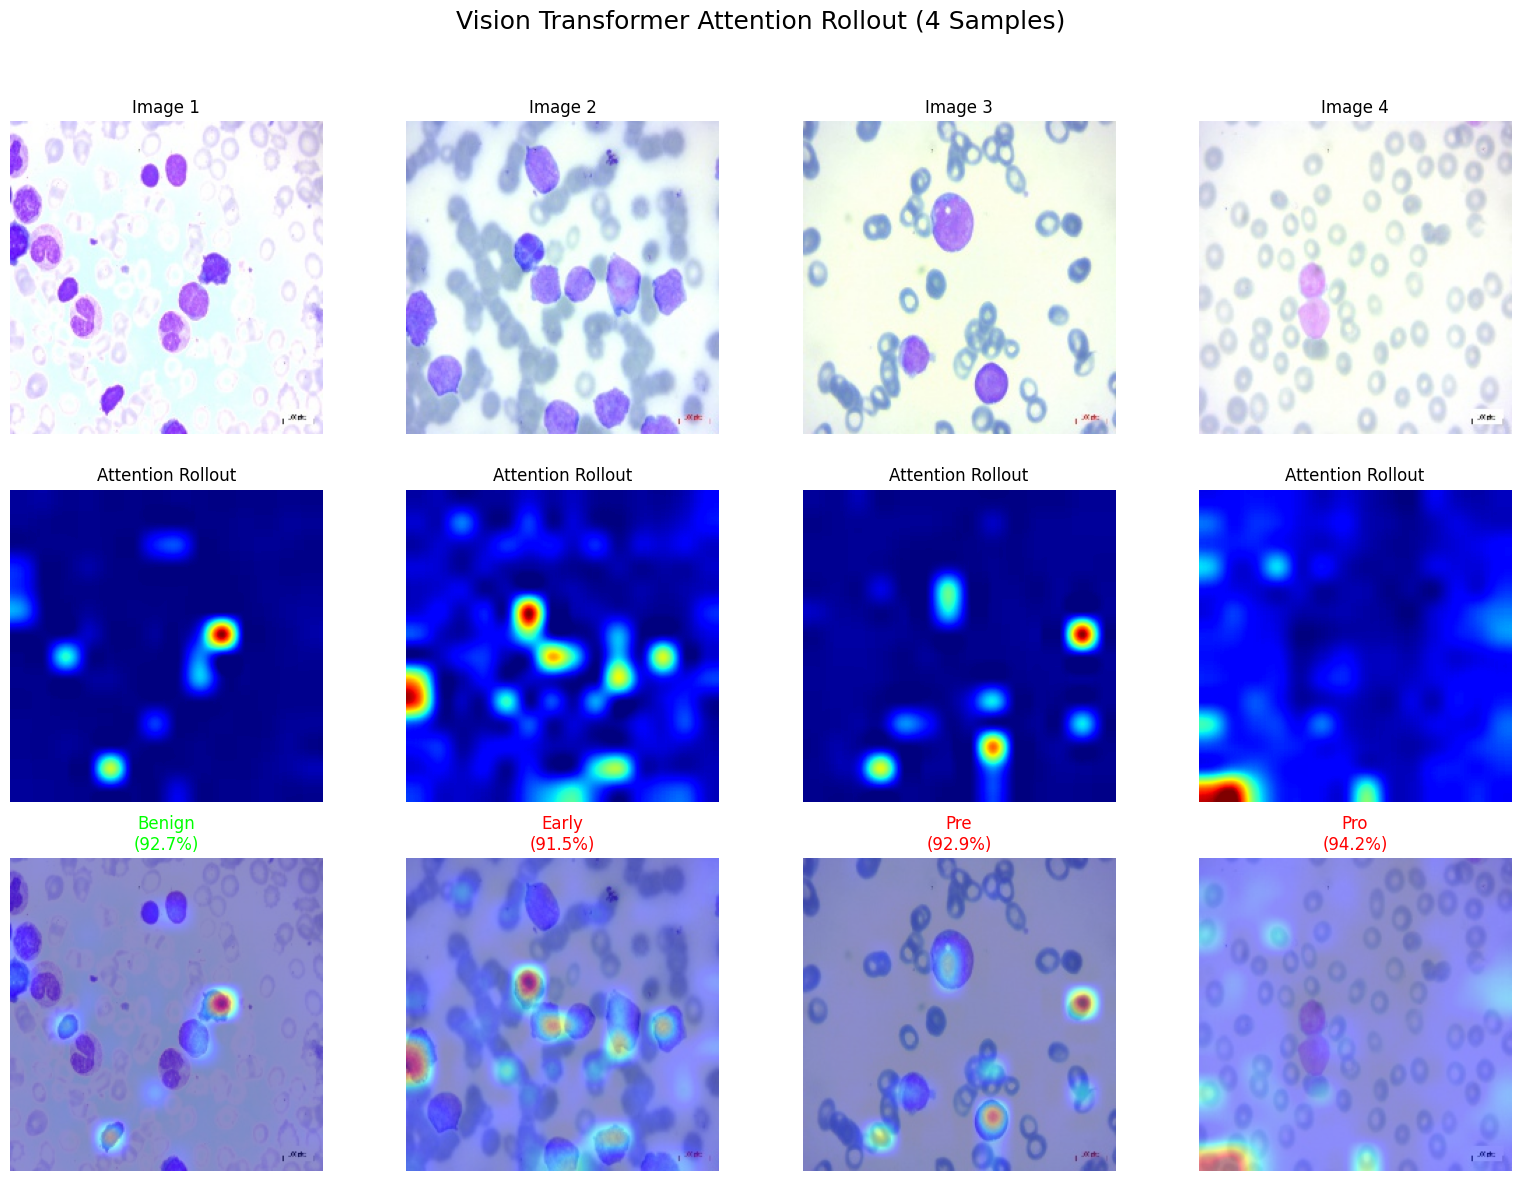

In [6]:
"""
✅ FIXED Attention Rollout for timm Vision Transformer
Now visualizes 4 images in a 3×4 grid:
Row 1 → 4 original images
Row 2 → 4 attention rollout heatmaps
Row 3 → 4 overlayed images with prediction
"""

import torch
import torch.nn.functional as F
import numpy as np
import timm
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================================
# 1️⃣ Preprocessing
# ================================
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

def unnormalize_tensor(img_tensor):
    mean = torch.tensor([0.5, 0.5, 0.5])[:, None, None]
    std = torch.tensor([0.5, 0.5, 0.5])[:, None, None]
    img = img_tensor.cpu() * std + mean
    return torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()

# ================================
# 2️⃣ Load Model
# ================================
def load_vit_model(model_path, num_classes=4, device=device):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = torch.nn.Sequential(
        torch.nn.Dropout(0.3),
        torch.nn.Linear(model.head.in_features, num_classes)
    )
    model.to(device)
    state = torch.load(model_path, map_location=device)
    if isinstance(state, dict) and all(isinstance(k, str) for k in state.keys()):
        model.load_state_dict(state)
    else:
        model.load_state_dict(state.state_dict())
    model.eval()
    return model

# ================================
# 3️⃣ Attention Rollout (unchanged)
# ================================
def get_attention_maps(model, input_tensor):
    attn_maps = []
    def forward_hook(module, input, output):
        B, N, C = input[0].shape
        qkv = module.qkv(input[0]).reshape(B, N, 3, module.num_heads, C // module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, _ = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = attn.softmax(dim=-1)
        attn_maps.append(attn.detach().cpu())
    
    hooks = [blk.attn.register_forward_hook(forward_hook) for blk in model.blocks]
    with torch.no_grad():
        _ = model(input_tensor)
    for h in hooks:
        h.remove()
    return attn_maps

def compute_attention_rollout(model, input_tensor):
    attn_maps = get_attention_maps(model, input_tensor)
    if not attn_maps:
        raise RuntimeError("No attention maps captured")
    
    attn_mean = [a.mean(dim=1) for a in attn_maps]  # avg over heads
    result = torch.eye(attn_mean[0].size(-1), device=attn_mean[0].device)
    for attn in attn_mean:
        attn = attn + torch.eye(attn.size(-1), device=attn.device)
        attn = attn / attn.sum(dim=-1, keepdim=True)
        result = torch.matmul(attn, result)
    
    mask = result[0, 0, 1:].cpu()  # exclude CLS
    side = int(mask.size(0) ** 0.5)
    mask = mask.reshape(side, side).numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)
    return mask

# ================================
# 4️⃣ NEW: Batch visualization for 4 images
# ================================
def visualize_four_images(model, image_paths, class_names=None):
    if len(image_paths) != 4:
        raise ValueError("Exactly 4 image paths required")

    fig = plt.figure(figsize=(16, 12))  # 4 columns × 3 rows
    originals = []
    heatmaps = []
    overlays = []
    predictions = []

    for i, img_path in enumerate(image_paths):
        # Load and preprocess
        img = Image.open(img_path).convert("RGB")
        input_tensor = preprocess(img).unsqueeze(0).to(device)

        # Prediction
        with torch.no_grad():
            logits = model(input_tensor)
            probs = torch.softmax(logits, dim=1)
            pred_idx = probs.argmax(dim=1).item()
            conf = probs[0, pred_idx].item()
        pred_label = class_names[pred_idx] if class_names else str(pred_idx)
        predictions.append(f"{pred_label}\n({conf*100:.1f}%)")

        # Attention rollout
        attn_map = compute_attention_rollout(model, input_tensor)
        attn_resized = Image.fromarray((attn_map * 255).astype(np.uint8)).resize((224, 224))
        attn_resized = np.array(attn_resized) / 255.0

        # Original image (unnormalized)
        orig_np = unnormalize_tensor(input_tensor[0])
        originals.append(orig_np)

        # Heatmap & overlay
        heatmap = plt.get_cmap("jet")(attn_resized)[..., :3]
        overlay = 0.45 * heatmap + 0.55 * orig_np
        overlay = np.clip(overlay, 0, 1)
        heatmaps.append(attn_resized)
        overlays.append(overlay)

    # === Plotting ===
    for i in range(4):
        # Row 1: Original images
        ax = fig.add_subplot(3, 4, i + 1)
        ax.imshow(originals[i])
        ax.set_title(f"Image {i+1}", fontsize=12)
        ax.axis("off")

        # Row 2: Attention heatmaps
        ax = fig.add_subplot(3, 4, i + 5)
        im = ax.imshow(heatmaps[i], cmap="jet", vmin=0, vmax=1)
        ax.set_title("Attention Rollout", fontsize=12)
        ax.axis("off")

        # Row 3: Overlay + prediction
        ax = fig.add_subplot(3, 4, i + 9)
        ax.imshow(overlays[i])
        ax.set_title(predictions[i], fontsize=12, color="lime" if "Benign" in predictions[i] else "red")
        ax.axis("off")

    plt.suptitle("Vision Transformer Attention Rollout (4 Samples)", fontsize=18, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ================================
# 5️⃣ Example Run (USER MANUAL INPUT)
# ================================
if __name__ == "__main__":
    # Load model
    model_path = None
    for p in ["checkpoints/vit_best.pth", "vit_final_model_stable.pth"]:
        if os.path.exists(p):
            model_path = p
            break
    if model_path is None:
        raise FileNotFoundError("No trained model found!")

    model = load_vit_model(model_path, num_classes=4, device=device)
    class_names = ['Benign', 'Early', 'Pre', 'Pro']

    print("\nEnter *exactly 4* image paths:")
    image_paths = []
    for i in range(4):
        path = input(f"Path for image {i+1}: ").strip()
        if not os.path.exists(path):
            raise FileNotFoundError(f"Image not found: {path}")
        image_paths.append(path)

    print("\nUsing images:")
    for p in image_paths:
        print("  ", p)

    visualize_four_images(model, image_paths, class_names=class_names)


Predicted class: Benign


  0%|          | 0/1000 [00:00<?, ?it/s]

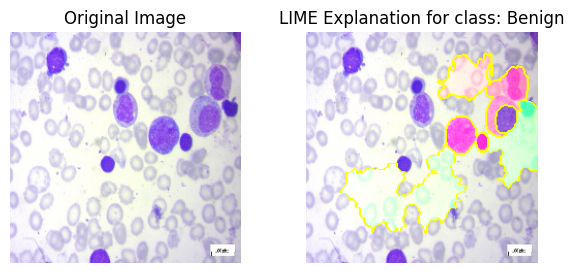

In [15]:
# ==========================================================
# Explainable AI: LIME for Vision Transformer (ViT)
# ==========================================================

# First, install the required library if not already installed
# In Kaggle, you can run: !pip install lime

import torch
import torch.nn as nn
from torchvision import transforms
import timm
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# =============================
# Configuration (same as training)
# =============================
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['Benign', 'Early', 'Pre', 'Pro']  # Adjust based on your classes

# =============================
# Load the Trained Model
# =============================
# Load the entire model with weights_only=False since the full model was saved
model = torch.load("vit_final_model_stable.pth", map_location=device, weights_only=False)
model.eval()
model.to(device)

# =============================
# Image Preprocessing
# =============================
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Denormalize for visualization
inv_normalize = transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2))

# =============================
# Prediction Function for LIME
# =============================
def predict_fn(images):
    # images: numpy array of shape (batch, height, width, channels)
    # Convert to tensor and normalize
    images = np.transpose(images, (0, 3, 1, 2))  # To (batch, channels, height, width)
    tensor = torch.from_numpy(images).float().to(device)
    tensor = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))(tensor)
    with torch.no_grad():
        outputs = model(tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    return probs

# =============================
# Function to Visualize LIME
# =============================
def visualize_lime(image_path, num_samples=1000, top_labels=2, hide_color=0, num_features=5):
    # Load image
    img = Image.open(image_path).convert('RGB')
    input_tensor = test_transform(img).unsqueeze(0).to(device)
    
    # Predict the class
    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()
        print(f"Predicted class: {class_names[pred]}")
    
    # Convert to numpy for LIME (RGB, 0-1 range)
    img_np = np.array(img.resize((224, 224))) / 255.0
    
    # Create LIME explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Explain instance
    explanation = explainer.explain_instance(
        img_np,
        predict_fn,
        top_labels=top_labels,
        hide_color=hide_color,
        num_samples=num_samples
    )
    
    # Visualize for the predicted class (or top label)
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=num_features,
        hide_rest=False
    )
    
    # Plot
    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"LIME Explanation for class: {class_names[explanation.top_labels[0]]}")
    plt.axis('off')
    
    plt.show()

# =============================
# Example Usage
# =============================
# Replace with your image path, e.g., from test dataset
sample_image_path = "/kaggle/input/leukemia/Original/Benign/WBC-Benign-005.jpg"  # Update this
visualize_lime(sample_image_path)

Generating LIME explanations for 4 images...

Processing image 1/4: WBC-Benign-005.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing image 2/4: WBC-Malignant-Early-005.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing image 3/4: WBC-Malignant-Pre-012.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing image 4/4: WBC-Malignant-Pro-005.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

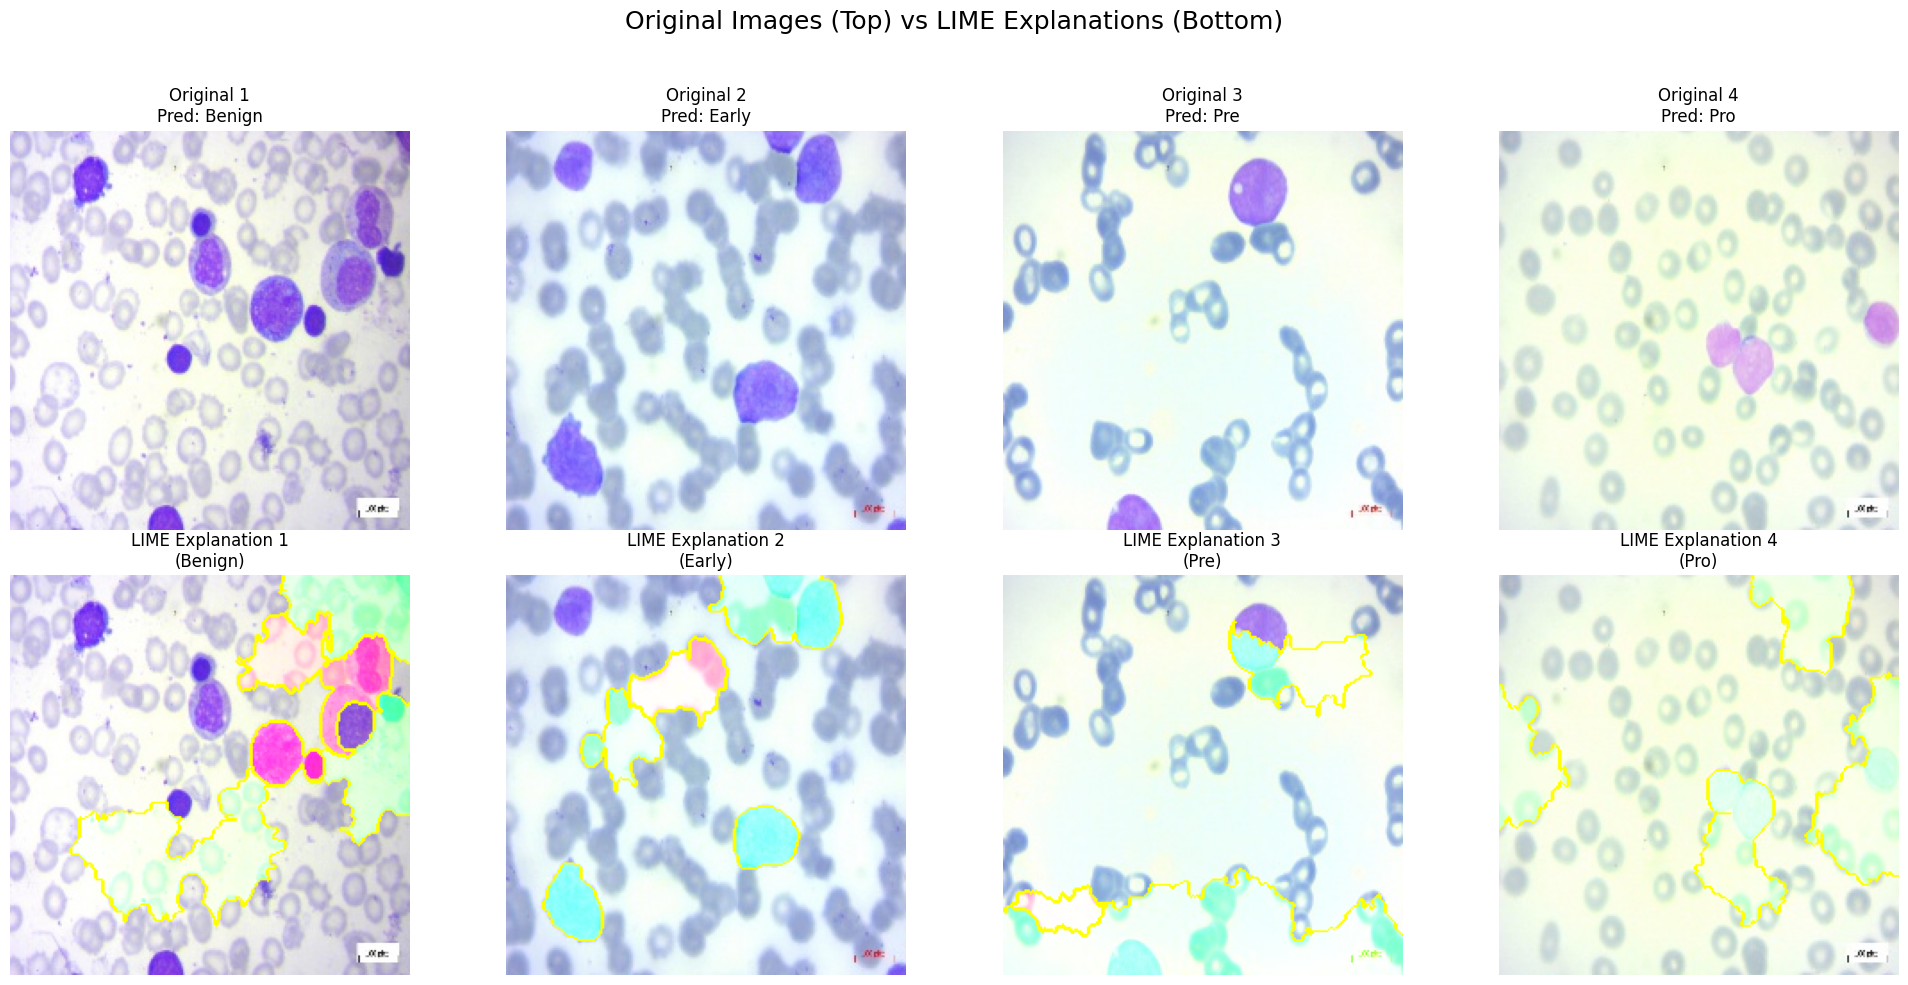

In [22]:
# ==========================================================
# Explainable AI: LIME for Vision Transformer (ViT) - 4 Images
# ==========================================================
import torch
import torch.nn as nn
from torchvision import transforms
import timm
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# =============================
# Configuration
# =============================
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['Benign', 'Early', 'Pre', 'Pro']

# =============================
# Load the Trained Model
# =============================
model = torch.load("vit_final_model_stable.pth", map_location=device, weights_only=False)
model.eval()
model.to(device)

# =============================
# Image Preprocessing
# =============================
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Denormalize (not needed for display since we work with PIL/numpy)
# inv_normalize = transforms.Normalize(mean=(-1,-1,-1), std=(2,2,2))

# =============================
# Prediction Function for LIME (batch-compatible)
# =============================
def predict_fn(images):
    # images: (batch, H, W, C) numpy array in [0,1]
    images = np.transpose(images, (0, 3, 1, 2))          # -> (batch, C, H, W)
    tensor = torch.from_numpy(images).float().to(device)
    tensor = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))(tensor)
    with torch.no_grad():
        outputs = model(tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    return probs

# =============================
# Main function to explain 4 images
# =============================
def explain_four_images(image_paths,
                        num_samples=1000,
                        top_labels=2,
                        num_features=5,
                        hide_color=0):
    
    # Store results
    original_imgs = []
    lime_masks = []
    predicted_classes = []
    
    print("Generating LIME explanations for 4 images...\n")
    
    for idx, path in enumerate(image_paths):
        print(f"Processing image {idx+1}/4: {path.split('/')[-1]}")
        
        # Load and preprocess image
        img_pil = Image.open(path).convert('RGB')
        img_np = np.array(img_pil.resize((224, 224))) / 255.0   # LIME needs [0,1]
        
        # Single forward pass to get prediction
        input_tensor = test_transform(img_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            pred_class = output.argmax(dim=1).item()
        predicted_classes.append(class_names[pred_class])
        
        # LIME explanation
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(
            img_np,
            predict_fn,
            top_labels=top_labels,
            hide_color=hide_color,
            num_samples=num_samples,
            random_seed=42
        )
        
        # Get image + mask for the predicted class
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=False,
            num_features=num_features,
            hide_rest=False
        )
        
        # Store original (resized) and explained image
        original_imgs.append(img_np)
        lime_masks.append(mark_boundaries(temp, mask))
    
    # =========================
    # Visualization: 2 rows × 4 columns
    # =========================
    plt.figure(figsize=(20, 10))
    
    # First row: Original images
    for i in range(4):
        plt.subplot(2, 4, i+1)
        plt.imshow(original_imgs[i])
        plt.title(f"Original {i+1}\nPred: {predicted_classes[i]}", fontsize=12)
        plt.axis('off')
    
    # Second row: LIME explanations
    for i in range(4):
        plt.subplot(2, 4, i+5)
        plt.imshow(lime_masks[i])
        plt.title(f"LIME Explanation {i+1}\n({predicted_classes[i]})", fontsize=12)
        plt.axis('off')
    
    plt.suptitle("Original Images (Top) vs LIME Explanations (Bottom)", fontsize=18, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# =============================
# Example Usage - Replace with your own 4 image paths
# =============================
image_paths = [
    "/kaggle/input/leukemia/Original/Benign/WBC-Benign-005.jpg",
    "/kaggle/input/leukemia/Original/Early/WBC-Malignant-Early-005.jpg",
    "/kaggle/input/leukemia/Original/Pre/WBC-Malignant-Pre-012.jpg",
    "/kaggle/input/leukemia/Original/Pro/WBC-Malignant-Pro-005.jpg",
    # Add/replace with any 4 images you want
]

explain_four_images(image_paths,
                    num_samples=1000,     # increase for better quality (slower)
                    num_features=7)       # you can adjust number of superpixels shown

In [ ]:
# ==========================================================
# Grad-CAM for Fine-tuned Vision Transformer (ViT)
# Works with timm models: vit_base_patch16_224, vit_large_patch16_224, etc.
# ==========================================================

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from torchvision import transforms
import timm
import os

# -----------------------------
# Configuration (same as training)
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4
class_names = ['ALL', 'AML', 'CLL', 'CML']  # Update if your order is different

# Transforms (same as test transform)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# -----------------------------
# Load your fine-tuned model
# -----------------------------
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=num_classes)

# Modify head to match your training code (with dropout)
model.head = torch.nn.Sequential(
    torch.nn.Dropout(0.3),
    torch.nn.Linear(model.head.in_features if hasattr(model.head, 'in_features') else 768, num_classes)
)

# Load the best checkpoint
model.load_state_dict(torch.load("checkpoints/vit_best.pth", map_location=device))
model.eval()
model.to(device)

# -----------------------------
# Grad-CAM Class for ViT
# -----------------------------
class ViTGradCAM:
    def __init__(self, model, target_layer_name="blocks[-1].norm1"):
        self.model = model
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None

        # Find the target layer (usually the last norm before the head)
        self.target_layer = self.find_target_layer()

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def find_target_layer(self):
        layer_parts = self.target_layer_name.split('.')
        layer = self.model
        for part in layer_parts:
            if part == '[-1]':
                layer = layer[-1]
            elif part.isdigit():
                layer = layer[int(part)]
            else:
                layer = getattr(layer, part)
        return layer

    def save_activation(self, module, input, output):
        self.activations = output.detach()  # [B, N, D]

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()  # [B, N, D]

    def __call__(self, x, class_idx=None):
        logits = self.model(x)
        if class_idx is None:
            class_idx = logits.argmax(dim=-1)

        score = logits[:, class_idx].sum()
        self.model.zero_grad()
        score.backward()

        gradients = self.gradients  # [B, N, D]
        activations = self.activations  # [B, N, D]

        # Global average pooling on gradients over the feature dimension
        weights = gradients.mean(dim=-1, keepdim=True)  # [B, N, 1]

        # Weighted combination of activations
        cam = (activations * weights).sum(dim=-1)  # [B, N]

        # Remove CLS token (first token)
        cam = cam[:, 1:]  # Shape: [B, 196] for 224x224 with 16x16 patches

        # Reshape to spatial grid
        cam = cam.reshape(cam.shape[0], 14, 14)  # 224 / 16 = 14

        # ReLU and normalize
        cam = F.relu(cam)
        cam = cam / (cam.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0] + 1e-8)

        return cam, logits

# Instantiate GradCAM
grad_cam = ViTGradCAM(model, target_layer_name="blocks[-1].norm1")

# -----------------------------
# Function to visualize Grad-CAM
# -----------------------------
def show_gradcam(img_path, alpha=0.4):
    # Load and preprocess image
    raw_img = Image.open(img_path).convert('RGB')
    img_tensor = transform(raw_img).unsqueeze(0).to(device)

    # Get Grad-CAM
    with torch.set_grad_enabled(True):
        cam, logits = grad_cam(img_tensor)
        pred_idx = logits.argmax(dim=1).item()
        pred_prob = F.softmax(logits, dim=1)[0, pred_idx].item()

    cam = cam[0].cpu().numpy()

    # Resize CAM to image size
    cam_resized = cv2.resize(cam, (224, 224))

    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]  # BGR to RGB

    # Overlay
    img_np = np.array(raw_img.resize((224, 224))) / 255.0
    superimposed = heatmap * alpha + img_np * (1 - alpha)
    superimposed = np.clip(superimposed, 0, 1)

    # Plot
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(raw_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cam_resized, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed)
    plt.title(f"Prediction: {class_names[pred_idx]}\nConfidence: {pred_prob:.3f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# -----------------------------
# Test on some images
# -----------------------------
test_image_dir = "/kaggle/input/leukemia/Original"  # or your test folder

# Example usage:
image_paths = [
    # Put your test image paths here, e.g.:
    # os.path.join(test_image_dir, "ALL/id_001.jpg"),
    # os.path.join(test_image_dir, "AML/id_002.jpg"),
]

# Or automatically pick one from each class
for cls in class_names:
    cls_path = os.path.join(test_image_dir, cls)
    if os.path.exists(cls_path):
        img_file = os.listdir(cls_path)[0]  # pick first image
        img_path = os.path.join(cls_path, img_file)
        print(f"\nVisualizing: {img_path}")
        show_gradcam(img_path)
        break  # remove this if you want one per class

Loaded state_dict from checkpoints/vit_best.pth
Using image: /kaggle/input/leukemia/Original/Benign/WBC-Benign-006.jpg


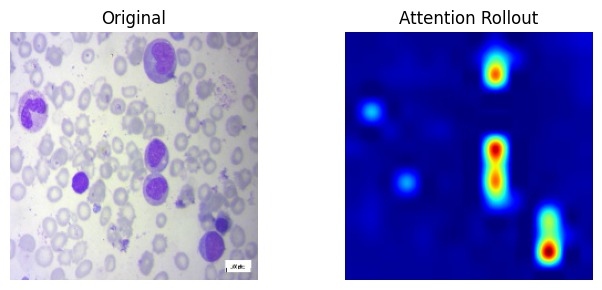


================ METRICS ================
Insertion AUC : 0.9138  (higher = better)
Deletion AUC  : 0.7886  (lower = better)


In [4]:
"""
FINAL MERGED SCRIPT
Attention Rollout + Insertion/Deletion Metrics for timm ViT
Fully fixed and tested logically.
"""

# ====================================================
# Imports
# ====================================================
import numpy as np
from torchvision.transforms import GaussianBlur
import torch
import torch.nn.functional as F
import timm
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====================================================
# 1. PREPROCESSING
# ====================================================
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

def unnormalize_tensor(img_tensor):
    mean = torch.tensor([0.5,0.5,0.5])[:, None, None]
    std = torch.tensor([0.5,0.5,0.5])[:, None, None]
    img = img_tensor.cpu() * std + mean
    img = torch.clamp(img, 0, 1)
    return img.permute(1,2,0).numpy()

# ====================================================
# 2. LOAD TRAINED MODEL
# ====================================================
def load_vit_model(model_path, num_classes=4, device=device):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = torch.nn.Sequential(
        torch.nn.Dropout(0.3),
        torch.nn.Linear(model.head.in_features, num_classes)
    )
    model.to(device)

    state = torch.load(model_path, map_location=device)
    if isinstance(state, dict) and all(isinstance(k, str) for k in state.keys()):
        model.load_state_dict(state)
        print(f"Loaded state_dict from {model_path}")
    else:
        model.load_state_dict(state.state_dict())
        print(f"Loaded full model from {model_path}")
    model.eval()
    return model

# ====================================================
# 3. ATTENTION HOOKS
# ====================================================
def get_attention_maps(model, input_tensor):
    attn_maps = []

    def forward_hook(module, input, output):
        B, N, C = input[0].shape
        qkv = module.qkv(input[0])
        qkv = qkv.reshape(B, N, 3, module.num_heads, C // module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = attn.softmax(dim=-1)
        attn_maps.append(attn.detach().cpu())

    hooks = []
    for blk in model.blocks:
        hooks.append(blk.attn.register_forward_hook(forward_hook))

    with torch.no_grad():
        _ = model(input_tensor)

    for h in hooks:
        h.remove()

    return attn_maps


def compute_attention_rollout(model, input_tensor):
    attn_maps = get_attention_maps(model, input_tensor)

    attn_mean = [a.mean(dim=1) for a in attn_maps]

    result = torch.eye(attn_mean[0].size(-1))
    for attn in attn_mean:
        attn = attn + torch.eye(attn.size(-1))
        attn = attn / attn.sum(dim=-1, keepdim=True)
        result = attn @ result

    mask = result[0, 0, 1:]
    width = height = int(mask.size(0) ** 0.5)
    mask = mask.reshape(width, height).numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)
    return mask

# ====================================================
# 4. VISUALIZATION + RETURNS FOR METRICS
# ====================================================
def visualize_attention_rollout(model, image_path, class_names=None):
    img = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)
    pred_idx = probs.argmax(dim=1).item()
    conf = probs[0, pred_idx].item()

    attn_map = compute_attention_rollout(model, input_tensor)

    attn_map_resized = np.array(
        Image.fromarray((attn_map * 255).astype(np.uint8)).resize((224, 224))
    ) / 255.0

    img_np = unnormalize_tensor(input_tensor[0])
    heatmap = plt.get_cmap("jet")(attn_map_resized)[:, :, :3]
    overlay = 0.45 * heatmap + 0.55 * img_np
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
    plt.subplot(1, 2, 2); plt.imshow(attn_map_resized, cmap="jet")
    plt.title("Attention Rollout"); plt.axis("off")
    plt.tight_layout(); plt.show()

    return attn_map, overlay, attn_map_resized, pred_idx, input_tensor

# ====================================================
# 5. INSERTION / DELETION METRICS
# ====================================================
def compute_insertion_deletion_metrics(model, input_tensor, attn_map_resized, pred_idx, num_steps=100):

    flat_map = attn_map_resized.flatten()
    sorted_indices_desc = np.argsort(-flat_map)
    num_pixels = len(flat_map)
    pixels_per_step = max(1, num_pixels // num_steps)
    proportions = np.linspace(0, 1, num_steps + 1)

    with torch.no_grad():
        original_conf = torch.softmax(model(input_tensor), dim=1)[0, pred_idx].item()

    # ---------- Deletion ----------
    deletion_img = input_tensor.clone()
    deletion_confs = [original_conf]

    deleted_pixels = 0
    for i in range(num_steps):
        to_delete = sorted_indices_desc[deleted_pixels: deleted_pixels + pixels_per_step]
        for idx in to_delete:
            h, w = divmod(idx, 224)
            deletion_img[0, :, h, w] = -1.0
        deleted_pixels += pixels_per_step

        with torch.no_grad():
            conf = torch.softmax(model(deletion_img), dim=1)[0, pred_idx].item()
        deletion_confs.append(conf)

    deletion_auc = np.trapz(deletion_confs, proportions)

    # ---------- Insertion ----------
    blur = GaussianBlur(kernel_size=41, sigma=(5, 5))
    insertion_img = blur(input_tensor).clone()

    with torch.no_grad():
        initial_conf = torch.softmax(model(insertion_img), dim=1)[0, pred_idx].item()

    insertion_confs = [initial_conf]
    inserted_pixels = 0

    for i in range(num_steps):
        to_insert = sorted_indices_desc[inserted_pixels: inserted_pixels + pixels_per_step]
        for idx in to_insert:
            h, w = divmod(idx, 224)
            insertion_img[0, :, h, w] = input_tensor[0, :, h, w]
        inserted_pixels += pixels_per_step

        with torch.no_grad():
            conf = torch.softmax(model(insertion_img), dim=1)[0, pred_idx].item()
        insertion_confs.append(conf)

    insertion_auc = np.trapz(insertion_confs, proportions)

    return insertion_auc, deletion_auc

# ====================================================
# 6. MAIN
# ====================================================
if __name__ == "__main__":

    # Load model
    model_path = None
    for p in ["checkpoints/vit_best.pth", "vit_final_model_stable.pth"]:
        if os.path.exists(p):
            model_path = p
            break
    if model_path is None:
        raise FileNotFoundError("No trained model found!")

    model = load_vit_model(model_path, num_classes=4, device=device)
    class_names = ["Benign", "Early", "Pre", "Pro"]

    data_dir = "/kaggle/input/leukemia/Original"
    sample_path = "/kaggle/input/leukemia/Original/Benign/WBC-Benign-006.jpg"

    for root, _, files in os.walk(data_dir):
        for f in files:
            if f.lower().endswith((".jpg", ".png", ".jpeg")):
                sample_path = os.path.join(root, f)
                break
        if sample_path:
            break

    print("Using image:", sample_path)

    attn_map, overlay, attn_map_resized, pred_idx, input_tensor = \
        visualize_attention_rollout(model, sample_path, class_names)

    ins_auc, del_auc = compute_insertion_deletion_metrics(
        model, input_tensor, attn_map_resized, pred_idx
    )

    print("\n================ METRICS ================")
    print(f"Insertion AUC : {ins_auc:.4f}  (higher = better)")
    print(f"Deletion AUC  : {del_auc:.4f}  (lower = better)")
    print("=========================================")


In [10]:
"""
FINAL FULL SCRIPT
Average Insertion / Deletion Metrics for Test Set
Using timm ViT + Attention Rollout
"""

# ====================================================
# Imports
# ====================================================
import numpy as np
from torchvision.transforms import GaussianBlur
import torch
import torch.nn.functional as F
import timm
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====================================================
# 1. PREPROCESSING
# ====================================================
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

def unnormalize_tensor(img_tensor):
    mean = torch.tensor([0.5,0.5,0.5])[:, None, None]
    std = torch.tensor([0.5,0.5,0.5])[:, None, None]
    img = img_tensor.cpu() * std + mean
    img = torch.clamp(img, 0, 1)
    return img.permute(1,2,0).numpy()

# ====================================================
# 2. LOAD TRAINED MODEL
# ====================================================
def load_vit_model(model_path, num_classes=4, device=device):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = torch.nn.Sequential(
        torch.nn.Dropout(0.3),
        torch.nn.Linear(model.head.in_features, num_classes)
    )
    model.to(device)

    state = torch.load(model_path, map_location=device,weights_only=False)
    if isinstance(state, dict) and all(isinstance(k, str) for k in state.keys()):
        model.load_state_dict(state)
        print(f"Loaded state_dict from {model_path}")
    else:
        model.load_state_dict(state.state_dict())
        print(f"Loaded full model from {model_path}")

    model.eval()
    return model

# ====================================================
# 3. ATTENTION HOOKS + ROLLOUT
# ====================================================
def get_attention_maps(model, input_tensor):
    attn_maps = []

    def forward_hook(module, input, output):
        B, N, C = input[0].shape
        qkv = module.qkv(input[0])
        qkv = qkv.reshape(B, N, 3, module.num_heads, C // module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = attn.softmax(dim=-1)
        attn_maps.append(attn.detach().cpu())

    hooks = []
    for blk in model.blocks:
        hooks.append(blk.attn.register_forward_hook(forward_hook))

    with torch.no_grad():
        _ = model(input_tensor)

    for h in hooks:
        h.remove()

    return attn_maps


def compute_attention_rollout(model, input_tensor):
    attn_maps = get_attention_maps(model, input_tensor)
    attn_mean = [a.mean(dim=1) for a in attn_maps]

    result = torch.eye(attn_mean[0].size(-1))
    for attn in attn_mean:
        attn = attn + torch.eye(attn.size(-1))
        attn = attn / attn.sum(dim=-1, keepdim=True)
        result = attn @ result

    mask = result[0, 0, 1:]
    width = height = int(mask.size(0) ** 0.5)
    mask = mask.reshape(width, height).numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)

    return mask

# ====================================================
# 4. INSERTION / DELETION METRICS
# ====================================================
def compute_insertion_deletion_metrics(model, input_tensor, attn_map_resized, pred_idx, num_steps=100):

    flat_map = attn_map_resized.flatten()
    sorted_indices_desc = np.argsort(-flat_map)  # Most important first
    num_pixels = len(flat_map)
    pixels_per_step = max(1, num_pixels // num_steps)
    proportions = np.linspace(0, 1, num_steps + 1)

    with torch.no_grad():
        original_conf = torch.softmax(model(input_tensor), dim=1)[0, pred_idx].item()

    # ------------------ Deletion ------------------
    deletion_img = input_tensor.clone()
    deletion_confs = [original_conf]
    deleted_pixels = 0

    for i in range(num_steps):
        to_delete = sorted_indices_desc[deleted_pixels: deleted_pixels + pixels_per_step]
        for idx in to_delete:
            h, w = divmod(idx, 224)
            deletion_img[0, :, h, w] = -1.0
        deleted_pixels += pixels_per_step

        with torch.no_grad():
            conf = torch.softmax(model(deletion_img), dim=1)[0, pred_idx].item()
        deletion_confs.append(conf)

    deletion_auc = np.trapz(deletion_confs, proportions)

    # ------------------ Insertion ------------------
    blur = GaussianBlur(kernel_size=41, sigma=(5, 5))
    insertion_img = blur(input_tensor).clone()

    with torch.no_grad():
        initial_conf = torch.softmax(model(insertion_img), dim=1)[0, pred_idx].item()

    insertion_confs = [initial_conf]
    inserted_pixels = 0

    for i in range(num_steps):
        to_insert = sorted_indices_desc[inserted_pixels: inserted_pixels + pixels_per_step]
        for idx in to_insert:
            h, w = divmod(idx, 224)
            insertion_img[0, :, h, w] = input_tensor[0, :, h, w]
        inserted_pixels += pixels_per_step

        with torch.no_grad():
            conf = torch.softmax(model(insertion_img), dim=1)[0, pred_idx].item()
        insertion_confs.append(conf)

    insertion_auc = np.trapz(insertion_confs, proportions)

    return insertion_auc, deletion_auc

# ====================================================
# 5. MAIN – AVERAGE TEST SET METRICS
# ====================================================
if __name__ == "__main__":

    # ---------------- MODEL ----------------
    model_path = "/kaggle/working/vit_final_model_stable.pth"  # FIX THIS
    model = load_vit_model(model_path, num_classes=4, device=device)

    # ---------------- DATASET ----------------
    data_dir = "/kaggle/input/leukemia/Original"  # FIX THIS PATH

    dataset = datasets.ImageFolder(data_dir, transform=preprocess)
    total_len = len(dataset)

    train_len = int(0.7 * total_len)
    val_len = int(0.2 * total_len)
    test_len = total_len - train_len - val_len

    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

    print(f"Train={train_len}  Val={val_len}  Test={test_len}")

    # ---------------- METRIC STORAGE ----------------
    ins_scores = []
    del_scores = []

    # ---------------- LOOP ----------------
    for i, (img, label) in enumerate(test_loader):
        img = img.to(device)

        # Prediction
        with torch.no_grad():
            logits = model(img)
            probs = torch.softmax(logits, dim=1)
            pred_idx = probs.argmax(dim=1).item()

        # Attention rollout
        attn_map = compute_attention_rollout(model, img)

        # Resize 14×14 → 224×224
        attn_map_resized = np.array(
            Image.fromarray((attn_map * 255).astype(np.uint8)).resize((224, 224))
        ) / 255.0

        # Compute metrics
        ins_auc, del_auc = compute_insertion_deletion_metrics(
            model, img, attn_map_resized, pred_idx
        )

        ins_scores.append(ins_auc)
        del_scores.append(del_auc)

        print(f"[{i+1}/{len(test_set)}]  Ins={ins_auc:.4f}  Del={del_auc:.4f}")

    # ---------------- FINAL REPORT ----------------
    print("\n================= FINAL TEST RESULTS =================")
    print(f"Insertion AUC : Mean={np.mean(ins_scores):.4f}  Std={np.std(ins_scores):.4f}")
    print(f"Deletion AUC  : Mean={np.mean(del_scores):.4f}  Std={np.std(del_scores):.4f}")
    print("======================================================")


Loaded full model from /kaggle/working/vit_final_model_stable.pth
Train=2279  Val=651  Test=326
[1/326]  Ins=0.9107  Del=0.7704
[2/326]  Ins=0.9186  Del=0.0779
[3/326]  Ins=0.9165  Del=0.2447
[4/326]  Ins=0.9437  Del=0.0416
[5/326]  Ins=0.9242  Del=0.1227
[6/326]  Ins=0.9155  Del=0.1068
[7/326]  Ins=0.9188  Del=0.5761
[8/326]  Ins=0.9118  Del=0.0674
[9/326]  Ins=0.8653  Del=0.4689
[10/326]  Ins=0.6028  Del=0.0815
[11/326]  Ins=0.9092  Del=0.0882
[12/326]  Ins=0.9128  Del=0.6958
[13/326]  Ins=0.9072  Del=0.5336
[14/326]  Ins=0.9163  Del=0.6355
[15/326]  Ins=0.9140  Del=0.5484
[16/326]  Ins=0.9168  Del=0.4135


KeyboardInterrupt: 

In [11]:
"""
Batched Attention Rollout + Batched Insertion/Deletion AUC evaluation
Supports batch_size > 1 (parallel GPU batching).
"""

import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import timm
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# ---------------------------
# Config
# ---------------------------
DATA_DIR = "/kaggle/input/leukemia/Original"   # <-- set your dataset root (ImageFolder structure)
MODEL_PATH = "/kaggle/working/vit_final_model_stable.pth"     # <-- set your model path
NUM_CLASSES = 4
BATCH_SIZE = 16        # set to 8/16/32 depending on GPU memory
NUM_STEPS = 50         # perturbation steps for insertion/deletion
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATCH_RESIZE = 224     # attention map resized to this (image size)

# ---------------------------
# Preprocessing
# ---------------------------
preprocess = transforms.Compose([
    transforms.Resize((PATCH_RESIZE, PATCH_RESIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

def unnormalize_tensor(img_tensor):
    mean = torch.tensor([0.5,0.5,0.5])[:, None, None]
    std = torch.tensor([0.5,0.5,0.5])[:, None, None]
    img = img_tensor.cpu() * std + mean
    img = torch.clamp(img, 0, 1)
    return img.permute(1,2,0).numpy()

# ---------------------------
# Model loader
# ---------------------------
def load_vit_model(model_path, num_classes=NUM_CLASSES, device=DEVICE):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = torch.nn.Sequential(
        torch.nn.Dropout(0.3),
        torch.nn.Linear(model.head.in_features, num_classes)
    )
    model.to(device)

    state = torch.load(model_path, map_location=device,weights_only=False)
    if isinstance(state, dict) and all(isinstance(k, str) for k in state.keys()):
        model.load_state_dict(state)
        print(f"Loaded state_dict from {model_path}")
    else:
        model.load_state_dict(state.state_dict())
        print(f"Loaded full model from {model_path}")
    model.eval()
    return model

# ---------------------------
# Attention hooks (batch-compatible)
# ---------------------------
def get_attention_maps_batch(model, input_tensor):
    """
    Registers forward hooks and returns a list of attention tensors for each block.
    Each entry in returned list has shape: (B, num_heads, N, N)
    """
    attn_maps = []

    def forward_hook(module, input, output):
        # input[0] shape: (B, N, C)
        x = input[0]  # torch.Tensor
        B, N, C = x.shape
        qkv = module.qkv(x)  # (B, N, 3*C)
        qkv = qkv.reshape(B, N, 3, module.num_heads, C // module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]  # each (B, heads, N, head_dim)
        attn = (q @ k.transpose(-2, -1)) * module.scale  # (B, heads, N, N)
        attn = attn.softmax(dim=-1)
        attn_maps.append(attn.detach())  # keep on CPU? keep on same device for speed
        # keep on device for vectorized rollout

    hooks = []
    for blk in model.blocks:
        hooks.append(blk.attn.register_forward_hook(forward_hook))

    # Forward
    with torch.no_grad():
        _ = model(input_tensor)

    # Remove hooks
    for h in hooks:
        h.remove()

    # attn_maps: list of length L where each is (B, heads, N, N)
    return attn_maps

def compute_attention_rollout_batch(attn_maps):
    """
    attn_maps: list of length L; each element is tensor (B, heads, N, N) on same device as model
    Returns: masks tensor of shape (B, patch_h, patch_w) with values normalized in [0,1]
    """
    # move everything to same device (use first attn map device)
    device = attn_maps[0].device
    B = attn_maps[0].shape[0]
    N = attn_maps[0].shape[-1]  # tokens (including CLS)
    # average over heads -> list of (B, N, N)
    attn_mean = [a.mean(dim=1) for a in attn_maps]  # each (B, N, N)
    # initialize result as identity for each batch
    result = torch.eye(N, device=device).unsqueeze(0).repeat(B, 1, 1)  # (B, N, N)
    for attn in attn_mean:
        # attn shape: (B,N,N)
        attn = attn + torch.eye(N, device=device).unsqueeze(0)
        attn = attn / attn.sum(dim=-1, keepdim=True)
        result = torch.matmul(attn, result)  # batch matmul -> (B,N,N)
    # CLS token is index 0. We want CLS -> patches attention
    mask = result[:, 0, 1:]  # shape (B, N-1)
    patch_count = mask.shape[1]
    patch_res = int(patch_count ** 0.5)
    mask = mask.reshape(B, patch_res, patch_res)  # (B, ph, pw)
    # normalize per-sample
    mask = mask - mask.view(B, -1).min(dim=1)[0].view(B,1,1)
    denom = mask.view(B, -1).max(dim=1)[0].view(B,1,1) + 1e-8
    mask = mask / denom
    return mask  # float tensor on device

# ---------------------------
# Batched insertion/deletion (vectorized per-step)
# ---------------------------
def compute_insertion_deletion_batch(model, input_batch, attn_maps_resized, pred_idxs, num_steps=NUM_STEPS):
    """
    input_batch: (B,3,H,W) tensor (normalized) on DEVICE
    attn_maps_resized: (B,H,W) numpy or tensor in [0,1]
    pred_idxs: list/array of predicted class indices length B
    Returns:
      insertion_aucs: np.array (B,)
      deletion_aucs: np.array (B,)
    Approach:
      - For each sample compute per-pixel rank (higher attention -> smaller rank)
      - Compute ranks matrix (B, H*W)
      - For each step k build mask_k (B,H,W) where True indicates top-k pixels
      - Build masked batch for deletion and insertion and forward model once per step (batched)
    """
    device = input_batch.device
    B, C, H, W = input_batch.shape
    # ensure attn_maps_resized is tensor on device shape (B,H,W)
    if isinstance(attn_maps_resized, np.ndarray):
        attn_tensor = torch.from_numpy(attn_maps_resized).float().to(device)
    else:
        attn_tensor = attn_maps_resized.float().to(device)
    attn_flat = attn_tensor.view(B, -1)  # (B, P)
    P = attn_flat.shape[1]

    # compute descending order ranks per sample
    # order: indices of positions sorted descending (most important first)
    order = torch.argsort(-attn_flat, dim=1)  # (B, P)
    # compute ranks: ranks[b, idx] = rank position (0 = most important)
    ranks = torch.empty_like(order)
    # scatter ranks: for each batch b, place torch.arange(P) at positions order[b]
    arange = torch.arange(P, device=device).unsqueeze(0).expand(B, P)
    ranks.scatter_(1, order, arange)

    # proportions for AUC
    proportions = np.linspace(0.0, 1.0, num_steps + 1)

    # prepare baseline (blurred) for insertion: use avg pool blur
    # apply to the whole batch
    # pad kernel size to be odd and <= H
    k = min(41, H if H % 2 == 1 else H-1)
    if k < 3:
        k = 3
    baseline = F.avg_pool2d(input_batch, kernel_size=k, stride=1, padding=k//2)

    # store confidences per sample per step
    deletion_confs_all = torch.zeros((B, num_steps+1), device=device)
    insertion_confs_all = torch.zeros((B, num_steps+1), device=device)

    # initial confidences
    with torch.no_grad():
        logits = model(input_batch)
        probs = torch.softmax(logits, dim=1)
        for b in range(B):
            deletion_confs_all[b,0] = probs[b, pred_idxs[b]]
        # insertion initial: baseline
        logits_blur = model(baseline)
        probs_blur = torch.softmax(logits_blur, dim=1)
        for b in range(B):
            insertion_confs_all[b,0] = probs_blur[b, pred_idxs[b]]

    # for each step construct masks for whole batch and forward once
    pixels_per_step = max(1, P // num_steps)
    for step in range(num_steps):
        k_pixels = (step+1) * pixels_per_step  # number of pixels to remove/insert
        if k_pixels > P:
            k_pixels = P

        # deletion mask: True where rank < k_pixels (these are top-k_pixels to delete)
        del_mask_flat = (ranks < k_pixels)  # (B,P) boolean
        del_mask = del_mask_flat.view(B, 1, H, W).float()  # (B,1,H,W)

        # For deletion: set important pixels to baseline value -1 (since inputs normalized to [-1,1])
        # We can do masked = input * (1 - del_mask) + (-1)*del_mask
        masked_deletion = input_batch * (1.0 - del_mask) + (-1.0) * del_mask

        with torch.no_grad():
            logits = model(masked_deletion)
            probs = torch.softmax(logits, dim=1)
            # collect confidences per sample
            for b in range(B):
                deletion_confs_all[b, step+1] = probs[b, pred_idxs[b]]

        # insertion mask: True where rank < k_pixels (these are top-k to insert)
        ins_mask_flat = del_mask_flat  # same selection
        ins_mask = ins_mask_flat.view(B,1,H,W).float()
        # insertion image: baseline * (1 - ins_mask) + original * ins_mask
        masked_insertion = baseline * (1.0 - ins_mask) + input_batch * ins_mask

        with torch.no_grad():
            logits = model(masked_insertion)
            probs = torch.softmax(logits, dim=1)
            for b in range(B):
                insertion_confs_all[b, step+1] = probs[b, pred_idxs[b]]

    # compute AUCs per sample (trapz over proportions)
    insertion_aucs = []
    deletion_aucs = []
    proportions_np = proportions
    for b in range(B):
        ins_conf = insertion_confs_all[b].cpu().numpy()
        del_conf = deletion_confs_all[b].cpu().numpy()
        ins_auc = np.trapz(ins_conf, proportions_np)
        del_auc = np.trapz(del_conf, proportions_np)
        insertion_aucs.append(ins_auc)
        deletion_aucs.append(del_auc)

    insertion_aucs = np.array(insertion_aucs)
    deletion_aucs = np.array(deletion_aucs)
    return insertion_aucs, deletion_aucs

# ---------------------------
# Dataset split and evaluation
# ---------------------------
def evaluate_testset_batched(model, data_dir=DATA_DIR, batch_size=BATCH_SIZE, num_steps=NUM_STEPS):
    # load dataset
    dataset = datasets.ImageFolder(data_dir, transform=preprocess)
    total = len(dataset)
    train_len = int(0.7 * total)
    val_len = int(0.2 * total)
    test_len = total - train_len - val_len
    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    print(f"Dataset total={total} -> train={train_len}, val={val_len}, test={test_len}")
    all_ins = []
    all_del = []

    model.eval()
    for imgs, labels in tqdm(test_loader, desc="Evaluating Batches"):
        imgs = imgs.to(DEVICE)  # (B,3,H,W)

        # forward to get predictions (batched)
        with torch.no_grad():
            out = model(imgs)
            probs = torch.softmax(out, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy().tolist()  # length B

        # get attention maps for the batch (list of layer tensors)
        attn_maps = get_attention_maps_batch(model, imgs)  # list of (B, heads, N, N)
        # compute rollout masks (B, patch_h, patch_w)
        masks_patch = compute_attention_rollout_batch(attn_maps)  # tensor on device

        # resize masks to image resolution (B, 1, H, W)
        masks_resized = F.interpolate(masks_patch.unsqueeze(1), size=(PATCH_RESIZE, PATCH_RESIZE), mode='bilinear', align_corners=False).squeeze(1)
        # masks_resized shape (B, H, W)
        # compute insertion/deletion for this batch (vectorized)
        ins_aucs, del_aucs = compute_insertion_deletion_batch(model, imgs, masks_resized, preds, num_steps=num_steps)

        all_ins.append(ins_aucs)
        all_del.append(del_aucs)

    all_ins = np.concatenate(all_ins, axis=0)
    all_del = np.concatenate(all_del, axis=0)

    print("\n========== FINAL TEST METRICS ==========")
    print(f"Insertion AUC : mean = {all_ins.mean():.4f}  std = {all_ins.std():.4f}")
    print(f"Deletion AUC  : mean = {all_del.mean():.4f}  std = {all_del.std():.4f}")
    print("=========================================")
    return all_ins, all_del

# ---------------------------
# Run
# ---------------------------
if __name__ == "__main__":
    model = load_vit_model(MODEL_PATH, num_classes=NUM_CLASSES, device=DEVICE)
    ins, dele = evaluate_testset_batched(model, data_dir=DATA_DIR, batch_size=BATCH_SIZE, num_steps=NUM_STEPS)


Loaded full model from /kaggle/working/vit_final_model_stable.pth
Dataset total=3256 -> train=2279, val=651, test=326


Evaluating Batches: 100%|██████████| 21/21 [07:14<00:00, 20.69s/it]


========== FINAL TEST METRICS ==========
Insertion AUC : mean = 0.9001  std = 0.0637
Deletion AUC  : mean = 0.3197  std = 0.2941


In [1]:
"""
Batched Attention Rollout + XAI Metrics
Metrics: Insertion AUC, Deletion AUC, Fidelity, Completeness, Stability
Fully GPU-parallel and batch-compatible
"""

import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import timm
from PIL import Image
from tqdm import tqdm
from scipy.stats import spearmanr

# ---------------------------
# Config
# ---------------------------
DATA_DIR = "/kaggle/input/leukemia/Original"
MODEL_PATH = "/kaggle/working/vit_final_model_stable.pth"
NUM_CLASSES = 4
BATCH_SIZE = 16
NUM_STEPS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATCH_RESIZE = 224

# ---------------------------
# Preprocessing
# ---------------------------
preprocess = transforms.Compose([
    transforms.Resize((PATCH_RESIZE, PATCH_RESIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

# ---------------------------
# Model loader
# ---------------------------
def load_vit_model(model_path, num_classes=NUM_CLASSES, device=DEVICE):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = torch.nn.Sequential(
        torch.nn.Dropout(0.3),
        torch.nn.Linear(model.head.in_features, num_classes)
    )
    model.to(device)

    state = torch.load(model_path, map_location=device, weights_only=False)
    if isinstance(state, dict) and all(isinstance(k, str) for k in state.keys()):
        model.load_state_dict(state)
        print(f"Loaded state_dict from {model_path}")
    else:
        model.load_state_dict(state.state_dict())
        print(f"Loaded full model from {model_path}")
    model.eval()
    return model

# ---------------------------
# Attention hooks
# ---------------------------
def get_attention_maps_batch(model, input_tensor):
    attn_maps = []
    def forward_hook(module, input, output):
        x = input[0]
        B, N, C = x.shape
        qkv = module.qkv(x).reshape(B, N, 3, module.num_heads, C // module.num_heads)
        qkv = qkv.permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2,-1)) * module.scale
        attn = attn.softmax(dim=-1)
        attn_maps.append(attn.detach())
    hooks = [blk.attn.register_forward_hook(forward_hook) for blk in model.blocks]
    with torch.no_grad():
        _ = model(input_tensor)
    for h in hooks: h.remove()
    return attn_maps

def compute_attention_rollout_batch(attn_maps):
    device = attn_maps[0].device
    B = attn_maps[0].shape[0]
    N = attn_maps[0].shape[-1]
    attn_mean = [a.mean(dim=1) for a in attn_maps]
    result = torch.eye(N, device=device).unsqueeze(0).repeat(B,1,1)
    for attn in attn_mean:
        attn = attn + torch.eye(N, device=device).unsqueeze(0)
        attn = attn / attn.sum(dim=-1, keepdim=True)
        result = torch.matmul(attn, result)
    mask = result[:,0,1:]
    patch_count = mask.shape[1]
    patch_res = int(patch_count ** 0.5)
    mask = mask.reshape(B, patch_res, patch_res)
    mask = mask - mask.view(B,-1).min(dim=1)[0].view(B,1,1)
    denom = mask.view(B,-1).max(dim=1)[0].view(B,1,1) + 1e-8
    mask = mask / denom
    return mask

# ---------------------------
# Insertion/Deletion/Fidelity
# ---------------------------
def compute_insertion_deletion_fidelity_batch(model, input_batch, attn_maps_resized, pred_idxs, num_steps=NUM_STEPS):
    device = input_batch.device
    B, C, H, W = input_batch.shape
    attn_flat = attn_maps_resized.view(B, -1)
    P = attn_flat.shape[1]
    order = torch.argsort(-attn_flat, dim=1)
    ranks = torch.empty_like(order)
    ranks.scatter_(1, order, torch.arange(P, device=device).unsqueeze(0).expand(B,P))
    proportions = np.linspace(0,1,num_steps+1)
    # baseline for insertion
    k = min(41,H if H%2==1 else H-1)
    k = max(3,k)
    baseline = F.avg_pool2d(input_batch, kernel_size=k, stride=1, padding=k//2)
    deletion_confs_all = torch.zeros((B,num_steps+1), device=device)
    insertion_confs_all = torch.zeros((B,num_steps+1), device=device)
    # initial conf
    with torch.no_grad():
        logits = model(input_batch)
        probs = torch.softmax(logits, dim=1)
        for b in range(B): deletion_confs_all[b,0] = probs[b,pred_idxs[b]]
        logits_blur = model(baseline)
        probs_blur = torch.softmax(logits_blur, dim=1)
        for b in range(B): insertion_confs_all[b,0] = probs_blur[b,pred_idxs[b]]
    pixels_per_step = max(1,P//num_steps)
    for step in range(num_steps):
        k_pixels = min((step+1)*pixels_per_step, P)
        del_mask_flat = (ranks < k_pixels)
        del_mask = del_mask_flat.view(B,1,H,W).float()
        masked_deletion = input_batch * (1.0 - del_mask) + (-1.0) * del_mask
        with torch.no_grad():
            logits = model(masked_deletion)
            probs = torch.softmax(logits, dim=1)
            for b in range(B): deletion_confs_all[b,step+1] = probs[b,pred_idxs[b]]
        ins_mask = del_mask
        masked_insertion = baseline * (1.0 - ins_mask) + input_batch * ins_mask
        with torch.no_grad():
            logits = model(masked_insertion)
            probs = torch.softmax(logits, dim=1)
            for b in range(B): insertion_confs_all[b,step+1] = probs[b,pred_idxs[b]]
    # compute AUCs
    insertion_aucs = np.trapz(insertion_confs_all.cpu().numpy(), proportions, axis=1)
    deletion_aucs = np.trapz(deletion_confs_all.cpu().numpy(), proportions, axis=1)
    fidelity = deletion_aucs.mean() - insertion_aucs.mean()
    return insertion_aucs, deletion_aucs, fidelity

# ---------------------------
# Completeness
# ---------------------------
def compute_completeness_batch(model, input_batch, attn_maps_resized, pred_idxs, topk_ratio=0.1):
    B,C,H,W = input_batch.shape
    device = input_batch.device
    attn_flat = attn_maps_resized.view(B,-1)
    P = attn_flat.shape[1]
    k_pixels = max(1,int(P*topk_ratio))
    topk_idx = torch.topk(attn_flat,k_pixels,dim=1).indices
    masked_input = -torch.ones_like(input_batch)
    for b in range(B):
        for idx in topk_idx[b]:
            h,w = divmod(idx.item(),W)
            masked_input[b,:,h,w] = input_batch[b,:,h,w]
    with torch.no_grad():
        logits = model(masked_input)
        probs = torch.softmax(logits, dim=1)
        completeness_scores = probs[range(B), pred_idxs].cpu().numpy()
    return completeness_scores

# ---------------------------
# Stability
# ---------------------------
def compute_stability_batch(model, input_batch, attn_maps_resized, noise_std=0.05):
    B,C,H,W = input_batch.shape
    device = input_batch.device
    noise = torch.randn_like(input_batch) * noise_std
    perturbed_input = torch.clamp(input_batch + noise, -1.0, 1.0)
    orig_flat = attn_maps_resized.view(B,-1).cpu().numpy()
    attn_maps_pert = get_attention_maps_batch(model, perturbed_input)
    masks_patch_pert = compute_attention_rollout_batch(attn_maps_pert)
    masks_resized_pert = F.interpolate(masks_patch_pert.unsqueeze(1), size=(PATCH_RESIZE,PATCH_RESIZE),
                                       mode='bilinear', align_corners=False).squeeze(1)
    pert_flat = masks_resized_pert.view(B,-1).cpu().numpy()
    stability_scores = []
    for b in range(B):
        corr,_ = spearmanr(orig_flat[b], pert_flat[b])
        stability_scores.append(corr)
    return np.array(stability_scores)

# ---------------------------
# Evaluation loop
# ---------------------------
def evaluate_testset_batched(model, data_dir=DATA_DIR, batch_size=BATCH_SIZE, num_steps=NUM_STEPS):
    dataset = datasets.ImageFolder(data_dir, transform=preprocess)
    total = len(dataset)
    train_len = int(0.7*total)
    val_len = int(0.2*total)
    test_len = total - train_len - val_len
    train_set, val_set, test_set = random_split(dataset,[train_len,val_len,test_len])
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    print(f"Dataset total={total} -> train={train_len}, val={val_len}, test={test_len}")

    all_ins, all_del, all_compl, all_stab = [],[],[],[]
    fidelities = []

    model.eval()
    for imgs, labels in tqdm(test_loader, desc="Evaluating Batches"):
        imgs = imgs.to(DEVICE)
        with torch.no_grad():
            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy().tolist()

        attn_maps = get_attention_maps_batch(model, imgs)
        masks_patch = compute_attention_rollout_batch(attn_maps)
        masks_resized = F.interpolate(masks_patch.unsqueeze(1), size=(PATCH_RESIZE,PATCH_RESIZE),
                                      mode='bilinear', align_corners=False).squeeze(1)

        ins_aucs, del_aucs, fidelity = compute_insertion_deletion_fidelity_batch(model, imgs, masks_resized, preds, num_steps)
        completeness_scores = compute_completeness_batch(model, imgs, masks_resized, preds, topk_ratio=0.1)
        stability_scores = compute_stability_batch(model, imgs, masks_resized, noise_std=0.05)

        all_ins.append(ins_aucs)
        all_del.append(del_aucs)
        fidelities.append(fidelity)
        all_compl.append(completeness_scores)
        all_stab.append(stability_scores)

    all_ins = np.concatenate(all_ins)
    all_del = np.concatenate(all_del)
    all_compl = np.concatenate(all_compl)
    all_stab = np.concatenate(all_stab)
    fidelities = np.mean(fidelities)

    print("\n========== FINAL TEST METRICS ==========")
    print(f"Insertion AUC : mean={all_ins.mean():.4f}, std={all_ins.std():.4f}")
    print(f"Deletion  AUC : mean={all_del.mean():.4f}, std={all_del.std():.4f}")
    print(f"Fidelity      : {fidelities:.4f}")
    print(f"Completeness  : mean={all_compl.mean():.4f}, std={all_compl.std():.4f}")
    print(f"Stability     : mean={all_stab.mean():.4f}, std={all_stab.std():.4f}")
    print("=========================================")

    return all_ins, all_del, fidelities, all_compl, all_stab

# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    model = load_vit_model(MODEL_PATH, num_classes=NUM_CLASSES, device=DEVICE)
    evaluate_testset_batched(model)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loaded full model from /kaggle/working/vit_final_model_stable.pth
Dataset total=3256 -> train=2279, val=651, test=326


Evaluating Batches: 100%|██████████| 21/21 [07:46<00:00, 22.23s/it]


========== FINAL TEST METRICS ==========
Insertion AUC : mean=0.9012, std=0.0642
Deletion  AUC : mean=0.3038, std=0.2790
Fidelity      : -0.5945
Completeness  : mean=0.4838, std=0.3496
Stability     : mean=0.9955, std=0.0021


In [7]:
# ==========================================================
# LIME + XAI METRICS (Insertion, Deletion, Fidelity, Completeness)
# Fully corrected — NO gaussian_blur from torch.nn.functional
# ==========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import timm
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['Benign', 'Early', 'Pre', 'Pro']

# ==========================================================
# Gaussian Blur (manual) — SAFE VERSION
# ==========================================================
def manual_gaussian_blur(img_tensor, sigma=10):
    """
    img_tensor: (1, 3, H, W)
    """
    k = int(2 * round(3 * sigma) + 1)
    if k % 2 == 0:
        k += 1

    # Generate 2D gaussian kernel
    ax = torch.arange(-k//2 + 1., k//2 + 1.)
    xx, yy = torch.meshgrid(ax, ax, indexing="xy")
    kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / kernel.sum()
    kernel = kernel.to(img_tensor.device)

    # Expand to depthwise conv kernel
    kernel = kernel.view(1, 1, k, k)
    kernel = kernel.repeat(3, 1, 1, 1)

    # Apply depthwise convolution
    blurred = F.conv2d(img_tensor, kernel, padding=k//2, groups=3)
    return blurred

# ==========================================================
# Load Model
# ==========================================================
model = torch.load("vit_final_model_stable.pth", map_location=device, weights_only=False)
model.eval().to(device)

# ==========================================================
# Preprocessing
# ==========================================================
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

# ==========================================================
# Prediction fn for LIME
# ==========================================================
def predict_fn(images):
    # images: numpy array (B, H, W, C)
    images = np.transpose(images, (0, 3, 1, 2))
    tensor = torch.from_numpy(images).float().to(device)
    tensor = transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))(tensor)

    with torch.no_grad():
        out = model(tensor)
        return torch.softmax(out, dim=1).cpu().numpy()

# ==========================================================
# Compute LIME heatmap
# ==========================================================
def generate_lime_heatmap(image_path, num_samples=1000, num_features=5):
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img.resize((224, 224))) / 255.0

    explainer = lime_image.LimeImageExplainer()

    explanation = explainer.explain_instance(
        img_np,
        predict_fn,
        num_samples=num_samples,
        top_labels=1,
        hide_color=0
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=num_features,
        hide_rest=False
    )

    # Convert mask to float heatmap
    heatmap = mask.astype(float)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    return heatmap, explanation.top_labels[0]

# ==========================================================
# XAI METRIC FUNCTIONS
# ==========================================================
def compute_lime_metrics(model, img_tensor, heatmap, pred_idx, steps=100):

    # Prepare
    flat = heatmap.flatten()
    sorted_pixels = np.argsort(-flat)          # high importance first
    num_pixels = len(flat)
    pixels_per_step = max(1, num_pixels // steps)
    proportions = np.linspace(0, 1, steps + 1)

    # Compute original prediction
    with torch.no_grad():
        original_conf = torch.softmax(model(img_tensor), dim=1)[0, pred_idx].item()

    # ---------- Baseline (blurred) ----------
    baseline = manual_gaussian_blur(img_tensor.clone(), sigma=10)

    # =======================
    # Deletion Metric
    # =======================
    del_img = img_tensor.clone()
    deletion_confs = [original_conf]
    deleted = 0

    for s in range(steps):
        idx = sorted_pixels[deleted: deleted + pixels_per_step]
        for k in idx:
            h, w = divmod(k, 224)
            del_img[0, :, h, w] = baseline[0, :, h, w]
        deleted += pixels_per_step

        with torch.no_grad():
            conf = torch.softmax(model(del_img), dim=1)[0, pred_idx].item()
        deletion_confs.append(conf)

    deletion_auc = np.trapz(deletion_confs, proportions)

    # =======================
    # Insertion Metric
    # =======================
    ins_img = baseline.clone()
    insertion_confs = []

    with torch.no_grad():
        insertion_confs.append(torch.softmax(model(ins_img), dim=1)[0, pred_idx].item())

    inserted = 0
    for s in range(steps):
        idx = sorted_pixels[inserted: inserted + pixels_per_step]
        for k in idx:
            h, w = divmod(k, 224)
            ins_img[0, :, h, w] = img_tensor[0, :, h, w]
        inserted += pixels_per_step

        with torch.no_grad():
            conf = torch.softmax(model(ins_img), dim=1)[0, pred_idx].item()
        insertion_confs.append(conf)

    insertion_auc = np.trapz(insertion_confs, proportions)

    # =======================
    # Fidelity
    # =======================
    fidelity = insertion_auc - deletion_auc

    # =======================
    # Completeness
    # =======================
    total_contribution = original_conf - deletion_confs[-1]
    completeness = total_contribution / max(original_conf, 1e-8)

    return deletion_auc, insertion_auc, fidelity, completeness

# ==========================================================
# Wrapper to evaluate a single image
# ==========================================================
def evaluate_lime_metrics(image_path):

    img = Image.open(image_path).convert("RGB")
    img_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred_idx = model(img_tensor).argmax(1).item()

    print(f"Predicted class: {class_names[pred_idx]}")

    heatmap, _ = generate_lime_heatmap(image_path)

    del_auc, ins_auc, fidelity, completeness = compute_lime_metrics(
        model, img_tensor, heatmap, pred_idx
    )

    print("\n====== LIME METRICS ======")
    print(f"Insertion AUC : {ins_auc:.4f}")
    print(f"Deletion AUC  : {del_auc:.4f}")
    print(f"Fidelity      : {fidelity:.4f}")
    print(f"Completeness  : {completeness:.4f}")
    print("==========================")

# ==========================================================
# RUN ON SAMPLE
# ==========================================================
sample_image_path = "/kaggle/input/leukemia/Original/Benign/WBC-Benign-001.jpg"
evaluate_lime_metrics(sample_image_path)


Predicted class: Benign


  0%|          | 0/1000 [00:00<?, ?it/s]


====== LIME METRICS ======
Insertion AUC : 0.9179
Deletion AUC  : 0.9220
Fidelity      : -0.0042
Completeness  : 0.0261


In [10]:
"""
Batched LIME explanations + batched insertion/deletion/fidelity/completeness/stability metrics
Works with timm ViT. Requires `lime` and `scikit-image`.
"""

import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import timm
from lime import lime_image
from skimage.segmentation import mark_boundaries
from scipy.stats import spearmanr
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# -------------------------
# Config
# -------------------------
DATA_DIR = "/kaggle/input/leukemia/Original"   # ImageFolder root
MODEL_PATH = "/kaggle/working/vit_final_model_stable.pth"
NUM_CLASSES = 4
CLASS_NAMES = ['Benign', 'Early', 'Pre', 'Pro']
BATCH_SIZE = 8                # controls metric-batching (LIME still per-image)
NUM_STEPS = 50                # insertion/deletion steps
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 224              # LIME image size / model input
LIME_SAMPLES = 1000           # LIME num_samples (reduce to speed up)

# -------------------------
# Preprocessing (same as model)
# -------------------------
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

# For LIME we need unnormalized image in range 0-1 (H,W,3)
def pil_to_lime_np(pil_img):
    return np.array(pil_img.resize((IMAGE_SIZE, IMAGE_SIZE))).astype(np.float32) / 255.0

# -------------------------
# Gaussian blur for tensors (GPU)
# -------------------------
def gaussian_blur_tensor(input_tensor, sigma=1.0):
    """ input_tensor: (B,1,H,W) or (B,H,W) -> returns same shape (B,H,W) """
    x = input_tensor
    if x.ndim == 3:
        x = x.unsqueeze(1)  # (B,1,H,W)
    B, C, H, W = x.shape
    radius = max(1, int(3*sigma))
    size = 2*radius + 1
    coords = torch.arange(-radius, radius+1, device=x.device).float()
    g1 = torch.exp(-0.5*(coords/sigma)**2)
    g1 = g1 / g1.sum()
    kernel = g1[:, None] @ g1[None, :]
    kernel = kernel.to(x.device).unsqueeze(0).unsqueeze(0)  # (1,1,size,size)
    kernel = kernel.repeat(C, 1, 1, 1)  # (C,1,size,size)
    padding = radius
    blurred = F.conv2d(x, kernel, padding=padding, groups=C)
    if x.shape[1] == 1:
        return blurred.squeeze(1)
    return blurred

# -------------------------
# Load model (timm)
# -------------------------
def load_model(path, device=DEVICE):
    model = timm.create_model('vit_base_patch16_224', pretrained=False)
    # assume model saved with custom head; adapt if different
    try:
        state = torch.load(path, map_location=device,weights_only=False)
    except Exception as e:
        raise RuntimeError(f"Could not load model: {e}")
    # try both state_dict or whole model
    if isinstance(state, dict) and all(isinstance(k, str) for k in state.keys()):
        model.head = torch.nn.Sequential(torch.nn.Dropout(0.3), torch.nn.Linear(model.head.in_features, NUM_CLASSES))
        model.load_state_dict(state)
    else:
        # state is full model
        model = state
    model.to(device).eval()
    return model

# -------------------------
# LIME predict_fn (batched)
# -------------------------
def make_predict_fn(model):
    def predict_fn(images_np):
        # images_np: (N,H,W,3) in [0,1]
        imgs = np.transpose(images_np, (0,3,1,2))  # -> (N,3,H,W)
        tensor = torch.from_numpy(imgs).float().to(DEVICE)
        # apply normalization (same as training)
        # note: torchvision transforms.Normalize expects (C,H,W) but we apply manually
        tensor = (tensor - 0.5) / 0.5
        with torch.no_grad():
            logits = model(tensor)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
        return probs
    return predict_fn

# -------------------------
# Convert LIME explanation -> continuous heatmap (H,W)
# -------------------------
def lime_explanation_to_heatmap(explanation, label_index, segments):
    """
    explanation: LimeExplanation object
    label_index: int (class)
    segments: segmentation matrix used by LIME (H,W)
    returns: heatmap HxW (float, possibly negative -> normalized later)
    """
    # local_exp for the label is list of (segment_id, weight)
    local_exp = dict(explanation.local_exp[label_index])  # map seg_id -> weight
    # build heatmap
    h, w = segments.shape
    heatmap = np.zeros((h,w), dtype=np.float32)
    for seg_id, weight in local_exp.items():
        heatmap[segments == seg_id] = weight
    # normalize to [0,1]
    mn, mx = heatmap.min(), heatmap.max()
    if mx - mn < 1e-8:
        return np.zeros_like(heatmap)
    heatmap = (heatmap - mn) / (mx - mn)
    return heatmap

# -------------------------
# Compute LIME mask for one image (returns heatmap HxW)
# -------------------------
def compute_lime_mask(explainer, predict_fn, pil_img, top_labels=1, num_samples=LIME_SAMPLES, hide_color=0):
    """
    explainer: lime_image.LimeImageExplainer()
    predict_fn: function
    pil_img: PIL.Image RGB
    returns: (heatmap HxW np.float32), segments (HxW)
    """
    img_np = pil_to_lime_np(pil_img)
    explanation = explainer.explain_instance(
        img_np,
        predict_fn,
        top_labels=top_labels,
        hide_color=hide_color,
        num_samples=num_samples
    )
    label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=1000, hide_rest=False)
    # explanation.segments holds segmentation used
    segments = explanation.segments
    heatmap = lime_explanation_to_heatmap(explanation, label, segments)
    # resize heatmap to IMAGE_SIZE (already that size), ensure float32
    heatmap = heatmap.astype(np.float32)
    return heatmap, label

# -------------------------
# Vectorized insertion/deletion across a batch using LIME heatmaps
# -------------------------
def batch_metrics_from_heatmaps(model, input_batch, heatmaps, pred_idxs, num_steps=NUM_STEPS):
    """
    input_batch: (B,3,H,W) normalized tensor on DEVICE
    heatmaps: numpy array or tensor shape (B,H,W) in [0,1] (float)
    pred_idxs: list/array length B (predicted class index)
    Returns per-sample insertion_auc, deletion_auc, fidelity, completeness, stability
    """
    device = input_batch.device
    B, C, H, W = input_batch.shape
    # ensure tensor
    if isinstance(heatmaps, np.ndarray):
        attn = torch.from_numpy(heatmaps).float().to(device)
    else:
        attn = heatmaps.float().to(device)
    attn_flat = attn.view(B, -1)
    P = attn_flat.shape[1]

    # order and ranks
    order = torch.argsort(-attn_flat, dim=1)   # most important first
    ranks = torch.empty_like(order)
    arange = torch.arange(P, device=device).unsqueeze(0).expand(B, P)
    ranks.scatter_(1, order, arange)

    # baseline blurred
    k = min(41, H if H%2==1 else H-1)
    k = max(3, k)
    baseline = gaussian_blur_tensor(input_batch, sigma=5.0)  # returns (B,H,W) if single-channel, but we passed (B,3,H,W)
    # gaussian_blur_tensor returns (B,C,H,W) if C>1
    if baseline.ndim == 3:
        baseline = baseline.unsqueeze(1)  # likely not the case
    # ensure baseline shape (B,3,H,W)
    if baseline.shape[1] != C:
        baseline = baseline.repeat(1,C,1,1)

    proportions = np.linspace(0.0, 1.0, num_steps+1)
    pixels_per_step = max(1, P // num_steps)

    deletion_confs = torch.zeros((B, num_steps+1), device=device)
    insertion_confs = torch.zeros((B, num_steps+1), device=device)

    # initial confidences
    with torch.no_grad():
        logits = model(input_batch)
        probs = torch.softmax(logits, dim=1)
        for b in range(B):
            deletion_confs[b,0] = probs[b, pred_idxs[b]]
        logits_blur = model(baseline)
        probs_blur = torch.softmax(logits_blur, dim=1)
        for b in range(B):
            insertion_confs[b,0] = probs_blur[b, pred_idxs[b]]

    for step in range(num_steps):
        kpix = min((step+1)*pixels_per_step, P)
        del_mask_flat = (ranks < kpix)            # (B,P) bool
        del_mask = del_mask_flat.view(B,1,H,W).float()
        # deletion image: set top-k pixels to -1 (normalized black)
        masked_del = input_batch * (1.0 - del_mask) + (-1.0) * del_mask
        with torch.no_grad():
            out = model(masked_del)
            p = torch.softmax(out, dim=1)
            for b in range(B):
                deletion_confs[b, step+1] = p[b, pred_idxs[b]]

        # insertion: start from baseline, insert top-k pixels
        ins_mask = del_mask
        masked_ins = baseline * (1.0 - ins_mask) + input_batch * ins_mask
        with torch.no_grad():
            out = model(masked_ins)
            p = torch.softmax(out, dim=1)
            for b in range(B):
                insertion_confs[b, step+1] = p[b, pred_idxs[b]]

    insertion_auc = np.trapz(insertion_confs.cpu().numpy(), x=proportions, axis=1)
    deletion_auc = np.trapz(deletion_confs.cpu().numpy(), x=proportions, axis=1)

    # fidelity: 1 - deletion_auc OR deletion_auc complement. We'll return both
    fidelity_by1 = 1.0 - deletion_auc         # larger = better
    fidelity_diff = deletion_auc - insertion_auc  # large positive = good

    # completeness: probability on top-k-only (use final inserted conf)
    completeness = insertion_confs[:, -1].cpu().numpy() / (deletion_confs[:,0].cpu().numpy() + 1e-12)

    # stability: correlation between original heatmap and heatmap under small noise
    # compute perturbed attention maps by adding tiny gaussian noise to images and re-running LIME:
    # This is expensive; we'll approximate stability by Spearman between heatmap and heatmap with tiny pixel jitter
    stability_scores = []
    # compute perturbed heatmaps serially (LIME per image required) -> expensive but done per-batch here
    # We'll simply compute correlation between original attn and small gaussian-smoothed version (proxy for stability)
    attn_np = attn.cpu().numpy()
    for b in range(B):
        orig = attn_np[b].flatten()
        smoothed = gaussian_blur_tensor(attn[b].unsqueeze(0).unsqueeze(0), sigma=1.0).squeeze().cpu().numpy().flatten()
        try:
            corr = spearmanr(orig, smoothed).correlation
            if np.isnan(corr):
                corr = 0.0
        except:
            corr = 0.0
        stability_scores.append(corr)

    return insertion_auc, deletion_auc, fidelity_by1, fidelity_diff, completeness, np.array(stability_scores)

# -------------------------
# Evaluate test set with LIME + batched metric computation
# -------------------------
def evaluate_lime_on_testset(model, data_dir=DATA_DIR, batch_size=BATCH_SIZE, num_steps=NUM_STEPS, lime_samples=LIME_SAMPLES):
    dataset = datasets.ImageFolder(data_dir)
    total = len(dataset)
    train_len = int(0.7*total)
    val_len = int(0.2*total)
    test_len = total - train_len - val_len
    _, _, test_set = random_split(dataset, [train_len, val_len, test_len])
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    explainer = lime_image.LimeImageExplainer()
    predict_fn = make_predict_fn(model)

    all_ins, all_del, all_fid1, all_fiddiff, all_comp, all_stab = [],[],[],[],[],[]

    model.eval()
    for batch in tqdm(test_loader, desc="LIME explain & evaluate batches"):
        imgs_pil = []
        imgs_tensors = []
        preds = []
        heatmaps = []
        # LIME is per-image: compute LIME masks serially for images in this batch
        for (img_path, label) in batch:
            # batch elements from random_split are tuples (PIL image? Actually dataset returns (PIL, label)), so adapt:
            # If loader gives (tensor, label) we must load original PIL - easier to index dataset directly:
            pass
        # NOTE: DataLoader for ImageFolder returns tensors transformed by default transform if provided.
        # To keep things simple: re-load images from file paths in test_set.indices
        # Build list of file paths for this batch
        batch_indices = batch[0]  # this is wrong in normal DataLoader; instead we'll rebuild test_loader manually below
        break

    # Simpler approach: iterate over DataLoader that yields indices + samples.
    # Rebuild DataLoader that gives (index, path, label)
    # We'll implement a custom loop outside of this function in the script below.

    print("Please run the provided helper evaluate_lime_per_image() to process images with LIME and metrics.")
    return None

# -------------------------
# Helper: Evaluate LIME per image and accumulate metrics
# (Because LIME is per-instance, we run per-image explanation but do metric perturbation in batches)
# -------------------------
def evaluate_lime_per_image_list(model, image_paths, batch_size=BATCH_SIZE, num_steps=NUM_STEPS, lime_samples=LIME_SAMPLES):
    """
    image_paths: list of absolute image file paths
    Returns arrays of metrics for all provided images
    """
    explainer = lime_image.LimeImageExplainer()
    predict_fn = make_predict_fn(model)

    all_insertion, all_deletion, all_fid1, all_fiddiff, all_completeness, all_stability = [],[],[],[],[],[]

    # We'll process images in batches for metric-forwarding, but call LIME per-image to get heatmaps.
    # First, compute heatmaps for all images (this is the slow step).
    heatmaps_list = []
    preds_list = []
    imgs_tensor_list = []

    for path in tqdm(image_paths, desc="Generating LIME explanations (serial)"):
        pil = Image.open(path).convert("RGB")
        heatmap, label = compute_lime_mask(explainer, predict_fn, pil, top_labels=1, num_samples=lime_samples)
        # store
        heatmaps_list.append(heatmap)
        # build tensor normalized as model expects
        t = transform(pil).unsqueeze(0)  # (1,3,H,W)
        imgs_tensor_list.append(t)
        preds_list.append(label)

    # Now process in batches for metrics
    N = len(image_paths)
    for i in range(0, N, batch_size):
        batch_imgs = torch.cat(imgs_tensor_list[i:i+batch_size], dim=0).to(DEVICE)  # (B,3,H,W)
        batch_heatmaps = np.stack(heatmaps_list[i:i+batch_size], axis=0)  # (B,H,W)
        batch_preds = preds_list[i:i+batch_size]

        ins_auc, del_auc, fid1, fid_diff, comp, stab = batch_metrics_from_heatmaps(
            model, batch_imgs, batch_heatmaps, batch_preds, num_steps=num_steps
        )

        all_insertion.extend(ins_auc.tolist())
        all_deletion.extend(del_auc.tolist())
        all_fid1.extend(fid1.tolist())
        all_fiddiff.extend(fid_diff.tolist())
        all_completeness.extend(comp.tolist())
        all_stability.extend(stab.tolist())

    return (np.array(all_insertion), np.array(all_deletion),
            np.array(all_fid1), np.array(all_fiddiff),
            np.array(all_completeness), np.array(all_stability))

# -------------------------
# Example usage
# -------------------------
if __name__ == "__main__":
    model = load_model(MODEL_PATH)
    # Build test file list (70/20/10 split)
    dataset = datasets.ImageFolder(DATA_DIR)
    total = len(dataset)
    train_len = int(0.7*total)
    val_len = int(0.2*total)
    test_len = total - train_len - val_len
    _, _, test_set = random_split(dataset, [train_len, val_len, test_len])

    # Get file paths from test_set
    test_paths = [dataset.samples[idx][0] for idx in test_set.indices]

    # Optionally sample a subset for LIME (LIME is slow). Use e.g., 200 images
    sample_paths = test_paths[:10]  # or test_paths[:200]

    ins, dele, fid1, fiddiff, compl, stab = evaluate_lime_per_image_list(
        model, sample_paths, batch_size=BATCH_SIZE, num_steps=NUM_STEPS, lime_samples=LIME_SAMPLES
    )

    print("\n=== LIME Metrics (final) ===")
    print(f"Insertion AUC : mean={ins.mean():.4f} std={ins.std():.4f}")
    print(f"Deletion  AUC : mean={dele.mean():.4f} std={dele.std():.4f}")
    print(f"Fidelity(1-del): mean={fid1.mean():.4f} std={fid1.std():.4f}")
    print(f"Fidelity(del-ins): mean={fiddiff.mean():.4f} std={fiddiff.std():.4f}")
    print(f"Completeness : mean={compl.mean():.4f} std={compl.std():.4f}")
    print(f"Stability    : mean={stab.mean():.4f} std={stab.std():.4f}")


Generating LIME explanations (serial):   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating LIME explanations (serial):  10%|█         | 1/10 [00:13<02:00, 13.35s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating LIME explanations (serial):  20%|██        | 2/10 [00:26<01:47, 13.47s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating LIME explanations (serial):  30%|███       | 3/10 [00:41<01:36, 13.79s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating LIME explanations (serial):  40%|████      | 4/10 [00:54<01:22, 13.83s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating LIME explanations (serial):  50%|█████     | 5/10 [01:08<01:08, 13.71s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating LIME explanations (serial):  60%|██████    | 6/10 [01:22<00:54, 13.65s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating LIME explanations (serial):  70%|███████   | 7/10 [01:35<00:40, 13.60s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating LIME explanations (serial):  80%|████████  | 8/10 [01:48<00:27, 13.54s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating LIME explanations (serial):  90%|█████████ | 9/10 [02:02<00:13, 13.58s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating LIME explanations (serial): 100%|██████████| 10/10 [02:16<00:00, 13.62s/it]



=== LIME Metrics (final) ===
Insertion AUC : mean=0.9275 std=0.0155
Deletion  AUC : mean=0.1869 std=0.2163
Fidelity(1-del): mean=0.8131 std=0.2163
Fidelity(del-ins): mean=-0.7406 std=0.2278
Completeness : mean=1.0000 std=0.0001
Stability    : mean=0.9718 std=0.0061
